In [1]:
import pandas as pd
from debugpy.launcher.debuggee import process
from pandas.plotting import table
import seaborn as sns
import pm4py

from ImageExporter import df_image_exporter
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from SimplicityMetrics.Functions import *

## Pre-processing of Data

In [50]:
# Reading xes file
log = pm4py.read_xes('data/BPI Challenge 2017.xes')

C:\Users\kickb\OneDrive\Escritorio\Praktikum BPM and Process Simulation\Project_Loan_Applications_Analysis\.venv\Lib\site-packages\pm4py\utils.py:992: UserWarning: Install the optional requirement `rustxes` to import/export files faster.
  warnings.warn("Install the optional requirement `rustxes` to import/export files faster.")
parsing log, completed traces :: 100%|██████████| 31509/31509 [01:15<00:00, 416.08it/s]


In [6]:
# --- De-comment code for making pickle file ---
#file_name = 'data/data_log.pkl'
#with open(file_name, 'wb') as f:
    #pickle.dump(log, f)

In [2]:
# Load the log from .pkl file
file_name = "data/data_log.pkl"
log = 0
with open(file_name, "rb") as f:
    log = pickle.load(f)


In [192]:
# convert to dataframe
log_copy = log.copy()
df = pm4py.convert_to_dataframe(log_copy)

# Change of column names for simplicity
df.rename(columns={'case:concept:name' : 'caseID', 'concept:name' : 'taskID', 'org:resource' : 'originator',
                   'lifecycle:transition' : 'EventType', 'case:LoanGoal' : 'LoanGoal', 'case:RequestedAmount' : 'RequestedAmount', 'case:ApplicationType' : 'ApplicationType', 'time:timestamp' : 'Timestamp'}, inplace=True)

# Rename the caseID to A1, A2, A3, ... etc
unique_cases = df['caseID'].unique()
new_ids = [f'A{i+1}' for i in range(len(unique_cases))]
case_map = dict(zip(unique_cases, new_ids))
df['caseID'] = df['caseID'].map(case_map)
df.dropna(subset=['caseID'], inplace=True)
#df.to_csv("data/data_log.csv", index=False)
df[df['caseID'] == 'A10000']

Action originator                    taskID  EventOrigin  \
386134      Created     User_1      A_Create Application  Application   
386135  statechange     User_1               A_Submitted  Application   
386136      Created     User_1            W_Handle leads     Workflow   
386137      Deleted     User_1            W_Handle leads     Workflow   
386138      Created     User_1    W_Complete application     Workflow   
...             ...        ...                       ...          ...   
386209     Released   User_144  W_Assess potential fraud     Workflow   
386210     Obtained   User_138  W_Assess potential fraud     Workflow   
386211  statechange   User_144                  A_Denied  Application   
386212  statechange   User_144                 O_Refused        Offer   
386213      Deleted   User_144  W_Assess potential fraud     Workflow   

                       EventID EventType                        Timestamp  \
386134  Application_1567894569  complete 2016-05-12 07:24:03.925000+00:00   
386135     ApplState_625442693  complete 2016-05-12 07:24:04.084000+00:00   
386136     Workitem_1446223344  schedule 2016-05-12 07:24:04.336000+00:00   
386137      Workitem_335636170  withdraw 2016-05-12 07:24:40.096000+00:00   
386138      Workitem_999694989  schedule 2016-05-12 07:24:40.103000+00:00   
...                        ...       ...                              ...   
386209       Workitem_41777638   suspend 2016-06-14 07:47:14.974000+00:00   
386210     Workitem_1483066610    resume 2016-06-14 08:33:12.694000+00:00   
386211    ApplState_1271233495  complete 2016-06-14 11:46:23.205000+00:00   
386212   OfferState_1532652860  complete 2016-06-14 11:46:23.420000+00:00   
386213      Workitem_473727587  complete 2016-06-14 11:46:23.456000+00:00   

                      LoanGoal ApplicationType  caseID  RequestedAmount  \
386134  Other, see explanation      New credit  A10000           7550.0   
386135  Other, see explanation      New credit  A10000           7550.0   
386136  Other, see explanation      New credit  A10000           7550.0   
386137  Other, see explanation      New credit  A10000           7550.0   
386138  Other, see explanation      New credit  A10000           7550.0   
...                        ...             ...     ...              ...   
386209  Other, see explanation      New credit  A10000           7550.0   
386210  Other, see explanation      New credit  A10000           7550.0   
386211  Other, see explanation      New credit  A10000           7550.0   
386212  Other, see explanation      New credit  A10000           7550.0   
386213  Other, see explanation      New credit  A10000           7550.0   

        FirstWithdrawalAmount  NumberOfTerms Accepted  MonthlyCost Selected  \
386134                    NaN            NaN      NaN          NaN      NaN   
386135                    NaN            NaN      NaN          NaN      NaN   
386136                    NaN            NaN      NaN          NaN      NaN   
386137                    NaN            NaN      NaN          NaN      NaN   
386138                    NaN            NaN      NaN          NaN      NaN   
...                       ...            ...      ...          ...      ...   
386209                    NaN            NaN      NaN          NaN      NaN   
386210                    NaN            NaN      NaN          NaN      NaN   
386211                    NaN            NaN      NaN          NaN      NaN   
386212                    NaN            NaN      NaN          NaN      NaN   
386213                    NaN            NaN      NaN          NaN      NaN   

        CreditScore  OfferedAmount          OfferID  
386134          NaN            NaN              NaN  
386135          NaN            NaN              NaN  
386136          NaN            NaN              NaN  
386137          NaN            NaN              NaN  
386138          NaN            NaN              NaN  
...             ...            ...   

## Exploratory analysis

In [86]:
#checking the number of categories in column action
countAction = df['Action'].value_counts().reset_index(name='count')
print("This are the number of actions available:")
countAction


This are the number of actions available:


Action   count
0  statechange  358940
1     Obtained  255387
2      Created  223608
3     Released  215402
4      Deleted  148930

In [87]:
count_taskID = df['taskID'].value_counts().reset_index(name='count')
print("This are the number of tasks available:")
count_taskID

This are the number of tasks available:


taskID   count
0       W_Validate application  209496
1          W_Call after offers  191092
2      W_Call incomplete files  168529
3       W_Complete application  148900
4               W_Handle leads   47264
5               O_Create Offer   42995
6                    O_Created   42995
7     O_Sent (mail and online)   39707
8                 A_Validating   38816
9                   A_Accepted   31509
10        A_Create Application   31509
11                   A_Concept   31509
12                  A_Complete   31362
13                  O_Returned   23305
14                A_Incomplete   23055
15                 O_Cancelled   20898
16                 A_Submitted   20423
17                  O_Accepted   17228
18                   A_Pending   17228
19                 A_Cancelled   10431
20                   O_Refused    4695
21                    A_Denied    3753
22    W_Assess potential fraud    3282
23        O_Sent (online only)    2026
24     W_Shortened completion      238
25  W_Personal Loan collection      22

In [67]:
# number of EventOrigins
count_eventOrigins = df['EventOrigin'].value_counts().reset_index(name='count')
print("This are the number of events origins available:")
count_eventOrigins

This are the number of events origins available:


EventOrigin   count
0     Workflow  768823
1  Application  239595
2        Offer  193849

<Axes: ylabel='count'>

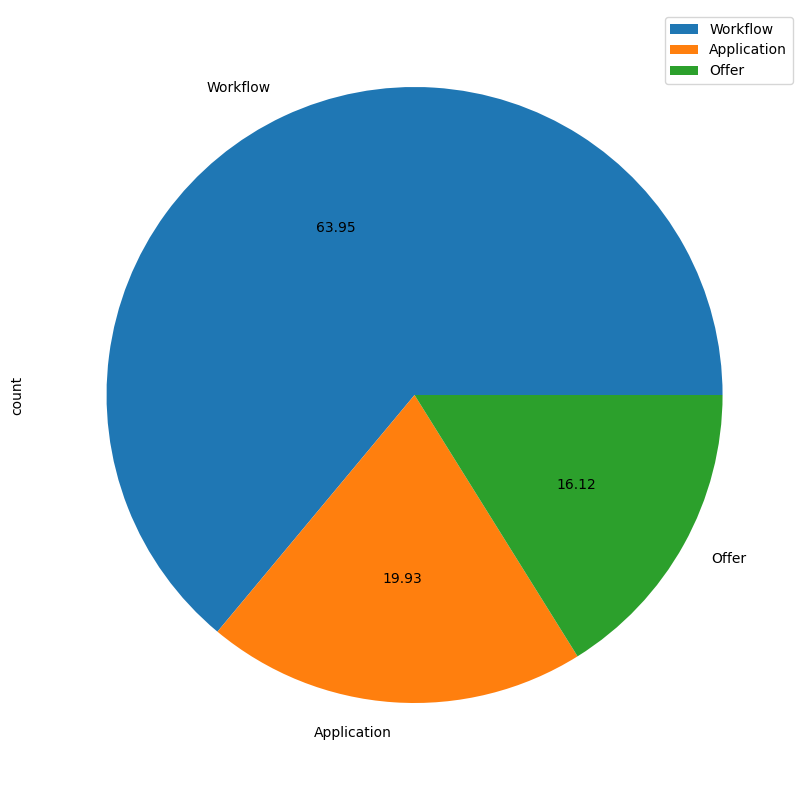

In [75]:
count_eventOrigins.plot.pie(labels=["Workflow", "Application", "Offer"], y='count', autopct="%.2f", figsize=(10,10))


In [47]:
''# number of eventType
count_eventType = df['EventType'].value_counts().reset_index(name='count')
print("This are the number of events type available:")
count_eventType

This are the number of events type available:


EventType   count
0   complete  475306
1    suspend  215402
2   schedule  149104
3      start  128227
4     resume  127160
5  ate_abort   85224
6   withdraw   21844

In [190]:
# number of ApplicationType
count_appType = df['ApplicationType'].value_counts().reset_index(name='count')
print("This are the ApplicationTypes available:")
count_appType

This are the number of ApplicationTypes available:


ApplicationType    count
0      New credit  1083767
1     Limit raise   118500

In [50]:
# calculate the lenght of each case
length_of_case = df.groupby('caseID')['caseID'].value_counts().reset_index(name='count')


mean_of_caseLength = length_of_case['count'].mean()
sd_of_caseLength = length_of_case['count'].std()

print("The mean of case length is: %2.f" % mean_of_caseLength)
print("The standard deviation of case length is: %2.f" % sd_of_caseLength)

The mean of case length is: 38
The standard deviation of case length is: 17


In [52]:
unique_count_loanGoal = df.groupby('caseID')['LoanGoal'].value_counts().reset_index(name='count')
count_of_uniq_loangoal = unique_count_loanGoal['LoanGoal'].value_counts().reset_index(name='count')
count_of_uniq_loangoal.index = count_of_uniq_loangoal.index + 1
df_image_exporter.create_image(count_of_uniq_loangoal, "Loan goals table.png")
count_of_uniq_loangoal


LoanGoal  count
1                      Car   9328
2         Home improvement   7669
3   Existing loan takeover   5601
4   Other, see explanation   2985
5                  Unknown   2365
6            Not speficied   1065
7      Remaining debt home    842
8     Extra spending limit    625
9         Caravan / Camper    369
10              Motorcycle    275
11                    Boat    201
12            Tax payments    152
13           Business goal     30
14      Debt restructuring      2

<Axes: ylabel='LoanGoal'>

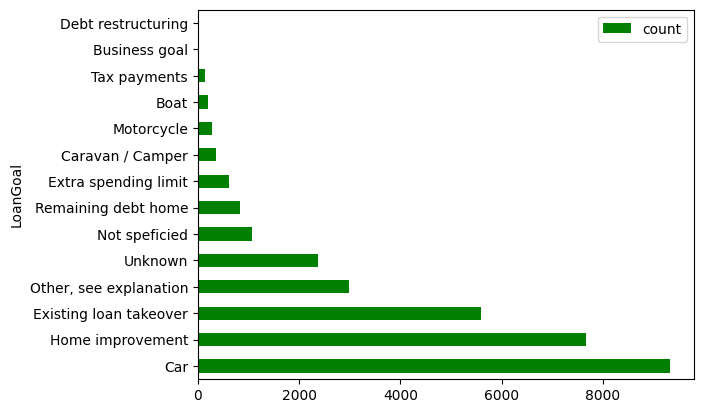

In [20]:
# Bar chart of loanGoals
count_of_uniq_loangoal.plot.barh(x='LoanGoal', y='count', color='green', rot=0)

#### Final outcomes per case

In [246]:
def determine_final_status(case_group: pd.DataFrame) -> str:

    task_ids = set(case_group['taskID'].astype(str))

    if ('O_Accepted' and 'A_Pending') in task_ids:
        return 'Accepted'

    elif 'O_Cancelled' in task_ids or 'A_Cancelled' in task_ids or 'A_Pending' and 'O_cancelled' in task_ids:
        return 'Cancelled'

    elif 'O_Denied' in task_ids or 'A_Denied' in task_ids or 'O_Refused' in task_ids:
        return 'Denied'

    else:
        return 'No Terminal Event Found'

In [170]:
df_copy = df.copy()
df_sorted = df_copy.sort_values(by=['caseID', 'Timestamp'], ascending=[True, False])

In [194]:
df_sorted['rank'] = df_sorted.groupby('caseID').cumcount() + 1
df_last_events = df_sorted[df_sorted['rank'] <= 3].copy()
df_last_events = df_last_events.sort_values(by=['caseID', 'Timestamp'], ascending=[True, True])

df_last_events = df_last_events.drop(columns=['rank'])

df_last_events


Action originator                  taskID  EventOrigin  \
37      statechange   User_115              O_Accepted        Offer   
38      statechange   User_115               A_Pending  Application   
39          Deleted   User_115  W_Validate application     Workflow   
384     statechange     User_1             A_Cancelled  Application   
385     statechange     User_1             O_Cancelled        Offer   
...             ...        ...                     ...          ...   
386091      Deleted    User_29  W_Validate application     Workflow   
386092  statechange    User_29             O_Cancelled        Offer   
386131  statechange    User_90              O_Accepted        Offer   
386132  statechange    User_90               A_Pending  Application   
386133      Deleted    User_90  W_Validate application     Workflow   

                      EventID  EventType                        Timestamp  \
37      OfferState_1093322349   complete 2016-01-14 15:49:11.416000+00:00   
38       ApplState_1179730815   complete 2016-01-14 15:49:11.420000+00:00   
39        Workitem_2067229931  ate_abort 2016-01-14 15:49:11.423000+00:00   
384       ApplState_910881174   complete 2016-02-02 07:00:34.729000+00:00   
385     OfferState_1613899155   complete 2016-02-02 07:00:34.753000+00:00   
...                       ...        ...                              ...   
386091     Workitem_431722224   complete 2016-06-06 10:24:34.978000+00:00   
386092  OfferState_1195943166   complete 2016-06-06 10:24:34.993000+00:00   
386131   OfferState_650138989   complete 2016-06-24 11:52:58.709000+00:00   
386132   ApplState_2068222861   complete 2016-06-24 11:52:58.712000+00:00   
386133     Workitem_666017012  ate_abort 2016-06-24 11:52:58.716000+00:00   

                      LoanGoal ApplicationType caseID  RequestedAmount  \
37      Existing loan takeover      New credit     A1          20000.0   
38      Existing loan takeover      New credit     A1          20000.0   
39      Existing loan takeover      New credit     A1          20000.0   
384                        Car      New credit    A10          11000.0   
385                        Car      New credit    A10          11000.0   
...                        ...             ...    ...              ...   
386091  Other, see explanation      New credit  A9998          37000.0   
386092  Other, see explanation      New credit  A9998          37000.0   
386131        Home improvement      New credit  A9999           5000.0   
386132        Home improvement      New credit  A9999           5000.0   
386133        Home improvement      New credit  A9999           5000.0   

        FirstWithdrawalAmount  NumberOfTerms Accepted  MonthlyCost Selected  \
37                        NaN            NaN      NaN          NaN      NaN   
38                        NaN            NaN      NaN          NaN      NaN   
39                        NaN            NaN      NaN          NaN      NaN   
384                       NaN            NaN      NaN          NaN      NaN   
385                       NaN            NaN      NaN          NaN      NaN   
...                       ...            ...      ...          ...      ...   
386091                    NaN            NaN      NaN          NaN      NaN   
386092                    NaN            NaN      NaN          NaN      NaN   
386131                    NaN            NaN      NaN          NaN      NaN   
386132                    NaN            NaN      NaN          NaN      NaN   
386133                    NaN            NaN      NaN          NaN      NaN   

        CreditScore  OfferedAmount           OfferID  
37              NaN            NaN   Offer_148581083  
38              NaN            NaN               NaN  
39              NaN            NaN               NaN  
384             NaN            NaN               NaN  
385             NaN            NaN   Offer_108214080  
...             ...            ...               ...  
386091      

In [247]:
# Determine final outcome #
static_attributes_df = df_last_events.drop_duplicates(subset=['caseID'])[
    ['caseID', 'ApplicationType', 'LoanGoal', 'RequestedAmount']
].set_index('caseID')

final_status = df_last_events.groupby('caseID').apply(determine_final_status).rename('final_status')

final_df = static_attributes_df.join(final_status).reset_index()

final_df


C:\Users\kickb\AppData\Local\Temp\ipykernel_32168\2292936303.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  final_status = df_last_events.groupby('caseID').apply(determine_final_status).rename('final_status')


caseID ApplicationType                LoanGoal  RequestedAmount  \
0          A1      New credit  Existing loan takeover          20000.0   
1         A10      New credit                     Car          11000.0   
2        A100      New credit                     Car           5500.0   
3       A1000     Limit raise                     Car          27000.0   
4      A10000      New credit  Other, see explanation           7550.0   
...       ...             ...                     ...              ...   
31504   A9995      New credit           Not speficied          55000.0   
31505   A9996      New credit        Home improvement           5000.0   
31506   A9997      New credit  Other, see explanation          27000.0   
31507   A9998      New credit  Other, see explanation          37000.0   
31508   A9999      New credit        Home improvement           5000.0   

      final_status  
0         Accepted  
1        Cancelled  
2        Cancelled  
3         Accepted  
4           Denied  
...            ...  
31504     Accepted  
31505    Cancelled  
31506     Accepted  
31507     Accepted  
31508     Accepted  

[31509 rows x 5 columns]

<Axes: ylabel='count'>

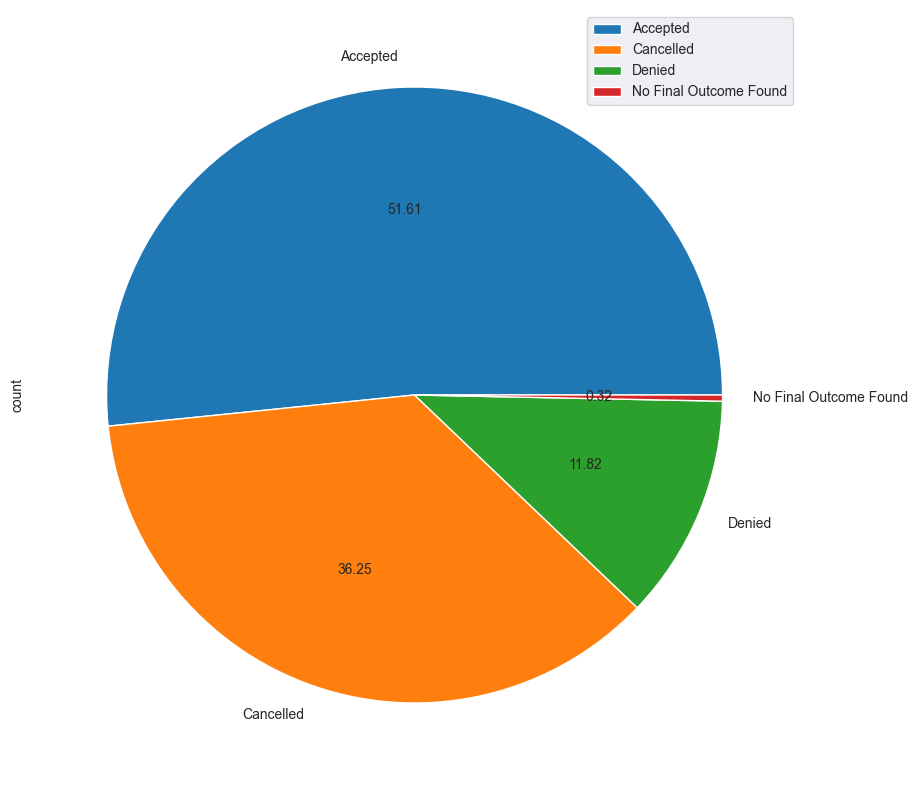

In [248]:
count_final_status = final_df['final_status'].value_counts().reset_index(name='count')
count_final_status
count_final_status.plot.pie(labels=["Accepted", "Cancelled", "Denied", "No Final Outcome Found"], y='count', autopct="%.2f", figsize=(10,10))

In [209]:
denied_cases = final_df[final_df['final_status'] == 'Denied']
counts_loanGoal = denied_cases['LoanGoal'].value_counts().reset_index(name='count')
counts_loanGoal

LoanGoal  count
0                      Car   1118
1         Home improvement    829
2   Existing loan takeover    780
3   Other, see explanation    403
4                  Unknown    207
5            Not speficied    145
6     Extra spending limit     92
7      Remaining debt home     46
8               Motorcycle     34
9             Tax payments     28
10        Caravan / Camper     22
11                    Boat     11
12           Business goal      8

In [211]:
accepted_cases = final_df[final_df['final_status'] == 'Accepted']
counts_loanGoal_accepted = accepted_cases['LoanGoal'].value_counts().reset_index(name='count')
counts_loanGoal_accepted

LoanGoal  count
0                      Car   4535
1         Home improvement   4257
2   Existing loan takeover   2875
3                  Unknown   1456
4   Other, see explanation   1436
5      Remaining debt home    468
6            Not speficied    403
7     Extra spending limit    320
8         Caravan / Camper    197
9               Motorcycle    133
10                    Boat    108
11            Tax payments     68
12           Business goal      7

In [213]:
cancelled_cases = final_df[final_df['final_status'] == 'Cancelled']
counts_loanGoal_cancelled = cancelled_cases['LoanGoal'].value_counts().reset_index(name='count')
counts_loanGoal_cancelled

LoanGoal  count
0                      Car   3654
1         Home improvement   2559
2   Existing loan takeover   1920
3   Other, see explanation   1135
4                  Unknown    700
5            Not speficied    509
6      Remaining debt home    321
7     Extra spending limit    211
8         Caravan / Camper    150
9               Motorcycle    108
10                    Boat     82
11            Tax payments     56
12           Business goal     15
13      Debt restructuring      2

In [220]:
# from the denied cases of car what was the avarg amount in comparison with the accepted ones

accepted_cases_car = accepted_cases[accepted_cases['LoanGoal'] == 'Car']
avrg_requested_amount = accepted_cases_car['RequestedAmount'].mean()

denied_cases_car = denied_cases[denied_cases['LoanGoal'] == 'Car']
avrg_requested_amount_1 = denied_cases_car['RequestedAmount'].mean()

print("The avg requested amount for accepted loan for cars is ", avrg_requested_amount, " and for denied loan for cars is ", avrg_requested_amount_1)

The avg requested amount for accepted loan for cars is  14089.937816979053  and for denied loan for cars is  12301.99016100179


In [225]:
highest_ra = final_df['RequestedAmount'].max()
most_expensive_loanGoal = final_df[final_df['RequestedAmount'] == highest_ra]
most_expensive_loanGoal

caseID ApplicationType          LoanGoal  RequestedAmount final_status
29435  A8131     Limit raise  Home improvement         450000.0     Accepted

In [265]:
# Rates of acceptance per loanGoal
accepted_rates = final_df.groupby('LoanGoal').agg(Total_application=('caseID', 'count'), Accepted_count=('final_status', lambda x: (x == 'Accepted').sum())).reset_index()
accepted_rates['Rate of Acceptance (%)'] = (accepted_rates['Accepted_count'] / accepted_rates['Total_application']) * 100

accepted_rates = accepted_rates.sort_values(by='Rate of Acceptance (%)', ascending=False).round(2)
accepted_rates.index = pd.RangeIndex(start=1, stop=len(accepted_rates) + 1, step=1)


In [264]:
# Rates of refusal (denied) per LoanGoal
denied_rates = final_df.groupby('LoanGoal').agg(Total_application=('caseID', 'count'), Denied_count=('final_status', lambda x: (x == 'Denied').sum())).reset_index()
denied_rates['Rate of refusal (%)'] = (denied_rates['Denied_count'] / denied_rates['Total_application']) * 100

denied_rates = denied_rates.sort_values(by='Rate of refusal (%)', ascending=False).round(2)
denied_rates.index = pd.RangeIndex(start=1, stop=len(denied_rates) +1 , step=1)

In [263]:
# Rates of cancelled cases per LoanGoal
cancelled_rates = final_df.groupby('LoanGoal').agg(Total_application=('caseID', 'count'), Cancelled_count=('final_status', lambda x: (x == 'Cancelled').sum())).reset_index()
cancelled_rates['Rate of cancelled cases (%)'] = (cancelled_rates['Cancelled_count'] / cancelled_rates['Total_application']) * 100

cancelled_rates = cancelled_rates.sort_values(by='Rate of cancelled cases (%)', ascending=False).round(2)
cancelled_rates.index = pd.RangeIndex(start=1, stop=len(cancelled_rates) + 1, step=1)

In [266]:
# Import images
df_image_exporter.create_image(accepted_rates, "Table_accepted_rates_loanGoal.png")
df_image_exporter.create_image(denied_rates, "Table_denied_rates_loanGoal.png")
df_image_exporter.create_image(cancelled_rates, "Table_cancelled_rates_loanGoal.png")

### Calculating durations of each event

In [18]:
df['Timestamp'] = pd.to_datetime((df['Timestamp']))

In [19]:
# sort data
df_with_duration = df.copy()

df_with_duration = df_with_duration.sort_values(by=['caseID', 'Timestamp'])

df_with_duration['end_timestamp'] = df_with_duration.groupby('caseID')['Timestamp'].shift(-1)

df_with_duration['duration'] = df_with_duration['end_timestamp'] - df_with_duration['Timestamp']

df_with_duration['durationSeconds'] = df_with_duration['duration'].dt.total_seconds()

df_with_duration.head(10)


Action originator                  taskID  EventOrigin  \
0      Created     User_1    A_Create Application  Application   
1  statechange     User_1             A_Submitted  Application   
2      Created     User_1          W_Handle leads     Workflow   
3      Deleted     User_1          W_Handle leads     Workflow   
4      Created     User_1  W_Complete application     Workflow   
5  statechange     User_1               A_Concept  Application   
6     Obtained    User_17  W_Complete application     Workflow   
7     Released    User_17  W_Complete application     Workflow   
8  statechange    User_52              A_Accepted  Application   
9      Created    User_52          O_Create Offer        Offer   

                 EventID EventType                        Timestamp  \
0  Application_652823628  complete 2016-01-01 09:51:15.304000+00:00   
1   ApplState_1582051990  complete 2016-01-01 09:51:15.352000+00:00   
2    Workitem_1298499574  schedule 2016-01-01 09:51:15.774000+00:00   
3    Workitem_1673366067  withdraw 2016-01-01 09:52:36.392000+00:00   
4    Workitem_1493664571  schedule 2016-01-01 09:52:36.403000+00:00   
5    ApplState_642383566  complete 2016-01-01 09:52:36.413000+00:00   
6    Workitem_1875340971     start 2016-01-02 10:45:22.429000+00:00   
7    Workitem_1452291795   suspend 2016-01-02 10:49:28.816000+00:00   
8     ApplState_99568828  complete 2016-01-02 11:23:04.299000+00:00   
9        Offer_148581083  complete 2016-01-02 11:29:03.994000+00:00   

                 LoanGoal ApplicationType caseID  ...  NumberOfTerms  \
0  Existing loan takeover      New credit     A1  ...            NaN   
1  Existing loan takeover      New credit     A1  ...            NaN   
2  Existing loan takeover      New credit     A1  ...            NaN   
3  Existing loan takeover      New credit     A1  ...            NaN   
4  Existing loan takeover      New credit     A1  ...            NaN   
5  Existing loan takeover      New credit     A1  ...            NaN   
6  Existing loan takeover      New credit     A1  ...            NaN   
7  Existing loan takeover      New credit     A1  ...            NaN   
8  Existing loan takeover      New credit     A1  ...            NaN   
9  Existing loan takeover      New credit     A1  ...           44.0   

   Accepted  MonthlyCost Selected  CreditScore OfferedAmount  OfferID  \
0       NaN          NaN      NaN          NaN           NaN      NaN   
1       NaN          NaN      NaN          NaN           NaN      NaN   
2       NaN          NaN      NaN          NaN           NaN      NaN   
3       NaN          NaN      NaN          NaN           NaN      NaN   
4       NaN          NaN      NaN          NaN           NaN      NaN   
5       NaN          NaN      NaN          NaN           NaN      NaN   
6       NaN          NaN      NaN          NaN           NaN      NaN   
7       NaN          NaN      NaN          NaN           NaN      NaN   
8       NaN          NaN      NaN          NaN           NaN      NaN   
9      True       498.29     True        979.0       20000.0      NaN   

                     end_timestamp               duration durationSeconds  
0 2016-01-01 09:51:15.352000+00:00 0 days 00:00:00.048000           0.048  
1 2016-01-01 09:51:15.774000+00:00 0 days 00:00:00.422000           0.422  
2 2016-01-01 09:52:36.392000+00:00 0 days 00:01:20.618000          80.618  
3 2016-01-01 09:52:36.403000+00:00 0 days 00:00:00.011000           0.011  
4 2016-01-01 09:52:36.413000+00:00 0 days 00:00:00.010000           0.010  
5 2016-01-02 10:45:22.429000+00:00 1 days 00:52:46.016000       89566.016  
6 2016-01-02 10:49:28.816000+00:00 0 days 00:04:06.387000         246.387  
7 2016-01-02 11:23:04.299000+00:00 0 days 00:33:35.483000        2015.483  
8 2016-01-02 11:29:03.994000+00:00 0 days 00:05:59.695000         359.695  
9 2016-01-02 11:29:05.354000+00:00 0 days 00:00:01.360000           1.360  

[10 rows x 22 columns]

In [20]:
case_duration_table = df_with_duration.groupby('caseID')['Timestamp'].agg(['min', 'max'])
case_duration_table['totalDuration'] = case_duration_table['max'] - case_duration_table['min']

case_duration_table['totalDuration_seconds'] = case_duration_table['totalDuration'].dt.total_seconds()
case_duration_table['totalDuration_hours'] = case_duration_table['totalDuration'].dt.total_seconds() / 3600

case_duration_table.head(10)

min                              max  \
caseID                                                                     
A1     2016-01-01 09:51:15.304000+00:00 2016-01-14 15:49:11.423000+00:00   
A10    2016-01-01 14:23:21.334000+00:00 2016-02-02 07:00:34.765000+00:00   
A100   2016-01-03 20:32:05.061000+00:00 2016-01-14 14:50:51.864000+00:00   
A1000  2016-01-15 08:19:57.758000+00:00 2016-01-26 10:43:14.819000+00:00   
A10000 2016-05-12 07:24:03.925000+00:00 2016-06-14 11:46:23.456000+00:00   
A10001 2016-05-12 07:24:26.132000+00:00 2016-06-13 06:00:22.603000+00:00   
A10002 2016-05-12 07:29:56.915000+00:00 2016-05-20 14:20:48.962000+00:00   
A10003 2016-05-12 07:32:55.825000+00:00 2016-05-20 17:21:56.309000+00:00   
A10004 2016-05-12 07:34:37.001000+00:00 2016-06-02 07:46:48.267000+00:00   
A10005 2016-05-12 07:39:33.079000+00:00 2016-06-10 06:46:04.283000+00:00   

                 totalDuration  totalDuration_seconds  totalDuration_hours  
caseID                                                                      
A1     13 days 05:57:56.119000            1144676.119           317.965589  
A10    31 days 16:37:13.431000            2738233.431           760.620397  
A100   10 days 18:18:46.803000             929926.803           258.313001  
A1000  11 days 02:23:17.061000             958997.061           266.388073  
A10000 33 days 04:22:19.531000            2866939.531           796.372092  
A10001 31 days 22:35:56.471000            2759756.471           766.599020  
A10002  8 days 06:50:52.047000             715852.047           198.847791  
A10003  8 days 09:49:00.484000             726540.484           201.816801  
A10004 21 days 00:12:11.266000            1815131.266           504.203129  
A10005 28 days 23:06:31.204000            2502391.204           695.108668

In [24]:
mean_case_duration = case_duration_table['totalDuration_hours'].mean()
sd_case_duration = case_duration_table['totalDuration_hours'].std()
mean_case_duration_full  = case_duration_table['totalDuration'].mean()
std_case_duration_full = case_duration_table['totalDuration'].std()
print("The mean of case duration(hours) is: %.2f and in days: %.2f" % (mean_case_duration, mean_case_duration/24))
print("The standard deviation of case duration(hours) is: %.2f and in days: %.2f" % (sd_case_duration, sd_case_duration/24))
print("Full format time duration mean: ", mean_case_duration_full)
print("Full format time duration standard deviation: ", std_case_duration_full)

The mean of case duration(hours) is: 525.59 and in days: 21.90
The standard deviation of case duration(hours) is: 316.06 and in days: 13.17
Full format time duration mean:  21 days 21:35:25.923069948
Full format time duration standard deviation:  13 days 04:03:41.690875763


### Plotting distribution of LoanGoals

In [34]:
# Assuming df_counts is your DataFrame
threshold = 150

# Create a new DataFrame for plotting
df_plot = count_of_uniq_loangoal.copy()

# Find all categories *below* the threshold and change their 'LoanGoal' to 'Other' -> 'Business Goal' and 'Debt restructuring'
df_plot.loc[df_plot['count'] < threshold, 'LoanGoal'] = 'Other'

# Now, group by the new 'LoanGoal' and sum the counts
df_plot_grouped = df_plot.groupby('LoanGoal')['count'].sum().reset_index()

# Sort for plotting
df_plot_grouped = df_plot_grouped.sort_values(by='count', ascending=False)

C:\Users\kickb\AppData\Local\Temp\ipykernel_9144\3114017387.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


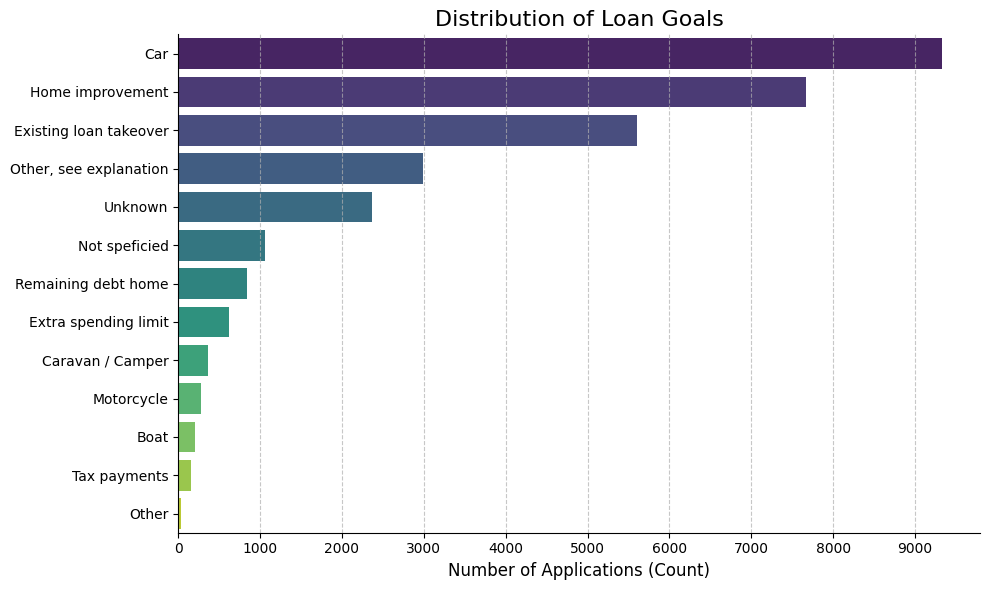

In [40]:
plt.figure(figsize=(10, 6))  # Can be a bit smaller now

ax = sns.barplot(
    x='count',
    y='LoanGoal',
    data=df_plot_grouped,
    palette='viridis'
)

plt.title('Distribution of Loan Goals', fontsize=16)
plt.xlabel('Number of Applications (Count)', fontsize=12)
plt.ylabel('')
sns.despine()

ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
ax.grid(True, axis='x', linestyle='--', alpha=0.7, zorder=0)

plt.tight_layout()
plt.show()

In [21]:
# Calculation of the avarage of event logs per related to a user
number_of_users = 31509
total_rows = len(df)
avg_logs_per_application = total_rows / number_of_users
print("The average number of event logs generated by an application/case: %.2f" % avg_logs_per_application)

The average number of event logs generated by an application/case: 38.16


In [61]:
# Number of single applications
number_of_applications = df['caseID'].nunique()
print("Number of total applications: %d" % number_of_applications)

Number of total applications: 31509


In [90]:
# Analyzing one single application (Application_652823628)
logs_for_one_application = df[df['caseID'] == "A5"]
logs_for_one_application

Action originator                    taskID  EventOrigin  \
200      Created     User_1      A_Create Application  Application   
201  statechange     User_1               A_Submitted  Application   
202      Created     User_1            W_Handle leads     Workflow   
203      Deleted     User_1            W_Handle leads     Workflow   
204      Created     User_1    W_Complete application     Workflow   
205  statechange     User_1                 A_Concept  Application   
206     Obtained    User_19    W_Complete application     Workflow   
207  statechange    User_19                A_Accepted  Application   
208      Created    User_19            O_Create Offer        Offer   
209  statechange    User_19                 O_Created        Offer   
210  statechange    User_19  O_Sent (mail and online)        Offer   
211      Deleted    User_19    W_Complete application     Workflow   
212      Created    User_19       W_Call after offers     Workflow   
213     Obtained    User_19       W_Call after offers     Workflow   
214  statechange    User_19                A_Complete  Application   
215     Released    User_19       W_Call after offers     Workflow   
216     Obtained    User_11       W_Call after offers     Workflow   
217     Released    User_11       W_Call after offers     Workflow   
218  statechange     User_1               A_Cancelled  Application   
219  statechange     User_1               O_Cancelled        Offer   
220      Deleted     User_1       W_Call after offers     Workflow   

                   EventID  EventType                        Timestamp  \
200  Application_828200680   complete 2016-01-01 13:00:04.360000+00:00   
201    ApplState_420123528   complete 2016-01-01 13:00:04.398000+00:00   
202    Workitem_1645277487   schedule 2016-01-01 13:00:04.737000+00:00   
203    Workitem_1902399339   withdraw 2016-01-01 13:01:44.651000+00:00   
204    Workitem_1933317539   schedule 2016-01-01 13:01:44.661000+00:00   
205    ApplState_281446729   complete 2016-01-01 13:01:44.671000+00:00   
206    Workitem_1987035323      start 2016-01-02 11:32:57.796000+00:00   
207    ApplState_873422308   complete 2016-01-02 11:40:45.797000+00:00   
208        Offer_607758096   complete 2016-01-02 11:42:23.751000+00:00   
209   OfferState_328204955   complete 2016-01-02 11:42:25.106000+00:00   
210  OfferState_1161306540   complete 2016-01-02 11:43:56.242000+00:00   
211     Workitem_975111658   complete 2016-01-02 11:43:56.259000+00:00   
212    Workitem_1704827982   schedule 2016-01-02 11:43:56.266000+00:00   
213    Workitem_1894841035      start 2016-01-02 11:43:56.269000+00:00   
214   ApplState_2090693037   complete 2016-01-02 11:43:56.271000+00:00   
215     Workitem_249716911    suspend 2016-01-02 11:46:13.901000+00:00   
216     Workitem_994377855     resume 2016-01-06 09:23:16.977000+00:00   
217    Workitem_1728082262    suspend 2016-01-06 09:23:42.346000+00:00   
218   ApplState_1001947261   complete 2016-02-02 07:00:20.734000+00:00   
219  OfferState_1690367453   complete 2016-02-02 07:00:20.837000+00:00   
220     Workitem_439808489  ate_abort 2016-02-02 07:00:20.849000+00:00   

             LoanGoal ApplicationType caseID  RequestedAmount  \
200  Home improvement      New credit     A5          35000.0   
201  Home improvement      New credit     A5          35000.0   
202  Home improvement      New credit     A5          35000.0   
203  Home improvement      New credit     A5          35000.0   
204  Home improvement      New credit     A5          35000.0   
205  Home improvement      New credit     A5          35000.0   
206  Home improvement      New credit     A5          35000.0   
207  Home improvement      New credit     A5          35000.0   
208  Home improvement      New credit     A5          35000.0   
209  Home improvement      New credit     A5          35000.0   
210  Home improvement      New credit     A5          35000.0   
211  Home improvement      New credit     A5          35000.

## Process Mining

In [55]:

variantes = pm4py.get_variants_as_tuples(log)

print("Variantes: ", len(variantes), " ,cases: ", len(log['case:concept:name'].unique()))


Variantes:  15930  ,cases:  31509


In [135]:
variantes_df = pd.DataFrame(sorted(variantes.items(), key=lambda x: x[1], reverse=True), columns = ["Variantes", 'Repeticiones'])
variantes_df

Variantes  Repeticiones
0      (A_Create Application, A_Submitted, W_Handle l...          1056
1      (A_Create Application, W_Complete application,...          1021
2      (A_Create Application, A_Submitted, W_Handle l...           734
3      (A_Create Application, A_Submitted, W_Handle l...           451
4      (A_Create Application, A_Submitted, W_Handle l...           332
...                                                  ...           ...
15925  (A_Create Application, A_Submitted, W_Handle l...             1
15926  (A_Create Application, W_Complete application,...             1
15927  (A_Create Application, W_Complete application,...             1
15928  (A_Create Application, A_Submitted, W_Handle l...             1
15929  (A_Create Application, A_Concept, W_Complete a...             1

[15930 rows x 2 columns]

### Distribution of variants (total = #cases)

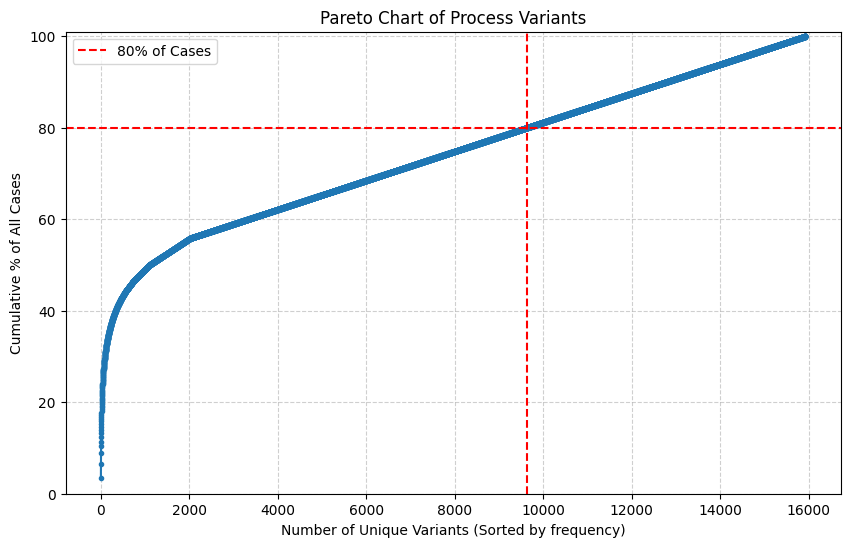

Results:
We have 15930 unique variants in total.
The top 9629 variants (out of 15930) cover 80% of all cases.


In [153]:
import matplotlib.ticker as ticker

total_reps = variantes_df['Repeticiones'].sum()
variantes_df['cum_perc'] = (variantes_df['Repeticiones'].cumsum() / total_reps) * 100

variantes_df['variant_count'] = np.arange(1, len(variantes_df) + 1)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(variantes_df['variant_count'], variantes_df['cum_perc'], marker='.')

plt.title('Pareto Chart of Process Variants')
plt.xlabel('Number of Unique Variants (Sorted by frequency)')
plt.ylabel('Cumulative % of All Cases')
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(0, 101)

plt.axhline(y=80, color='red', linestyle='--', label='80% of Cases')

variants_for_80_perc = (variantes_df['cum_perc'] <= 80).sum() + 1
plt.axvline(x=variants_for_80_perc, color='red', linestyle='--')

plt.legend()
plt.show()

print(f"Results:")
print(f"We have {len(variantes_df)} unique variants in total.")
print(f"The top {variants_for_80_perc} variants (out of {len(variantes_df)}) cover 80% of all cases.")

### Heuristic Miner

In [148]:
top = 9600
variants_simplified = pm4py.filter_variants_top_k(log, top)

Action org:resource            concept:name  EventOrigin  \
0      Created       User_1    A_Create Application  Application   
1  statechange       User_1             A_Submitted  Application   
2      Created       User_1          W_Handle leads     Workflow   
3      Deleted       User_1          W_Handle leads     Workflow   
4      Created       User_1  W_Complete application     Workflow   

                 EventID lifecycle:transition  \
0  Application_652823628             complete   
1   ApplState_1582051990             complete   
2    Workitem_1298499574             schedule   
3    Workitem_1673366067             withdraw   
4    Workitem_1493664571             schedule   

                    time:timestamp           case:LoanGoal  \
0 2016-01-01 09:51:15.304000+00:00  Existing loan takeover   
1 2016-01-01 09:51:15.352000+00:00  Existing loan takeover   
2 2016-01-01 09:51:15.774000+00:00  Existing loan takeover   
3 2016-01-01 09:52:36.392000+00:00  Existing loan takeover   
4 2016-01-01 09:52:36.403000+00:00  Existing loan takeover   

  case:ApplicationType      case:concept:name  case:RequestedAmount  \
0           New credit  Application_652823628               20000.0   
1           New credit  Application_652823628               20000.0   
2           New credit  Application_652823628               20000.0   
3           New credit  Application_652823628               20000.0   
4           New credit  Application_652823628               20000.0   

   FirstWithdrawalAmount  NumberOfTerms Accepted  MonthlyCost Selected  \
0                    NaN            NaN      NaN          NaN      NaN   
1                    NaN            NaN      NaN          NaN      NaN   
2                    NaN            NaN      NaN          NaN      NaN   
3                    NaN            NaN      NaN          NaN      NaN   
4                    NaN            NaN      NaN          NaN      NaN   

   CreditScore  OfferedAmount OfferID  
0          NaN            NaN     NaN  
1          NaN            NaN     NaN  
2          NaN            NaN     NaN  
3          NaN            NaN     NaN  
4          NaN            NaN     NaN

C:\Users\kickb\OneDrive\Escritorio\Praktikum BPM and Process Simulation\Project_Loan_Applications_Analysis\.venv\Lib\site-packages\pm4py\algo\discovery\dfg\adapters\pandas\df_statistics.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_timestamp_key] = df[timestamp_key]


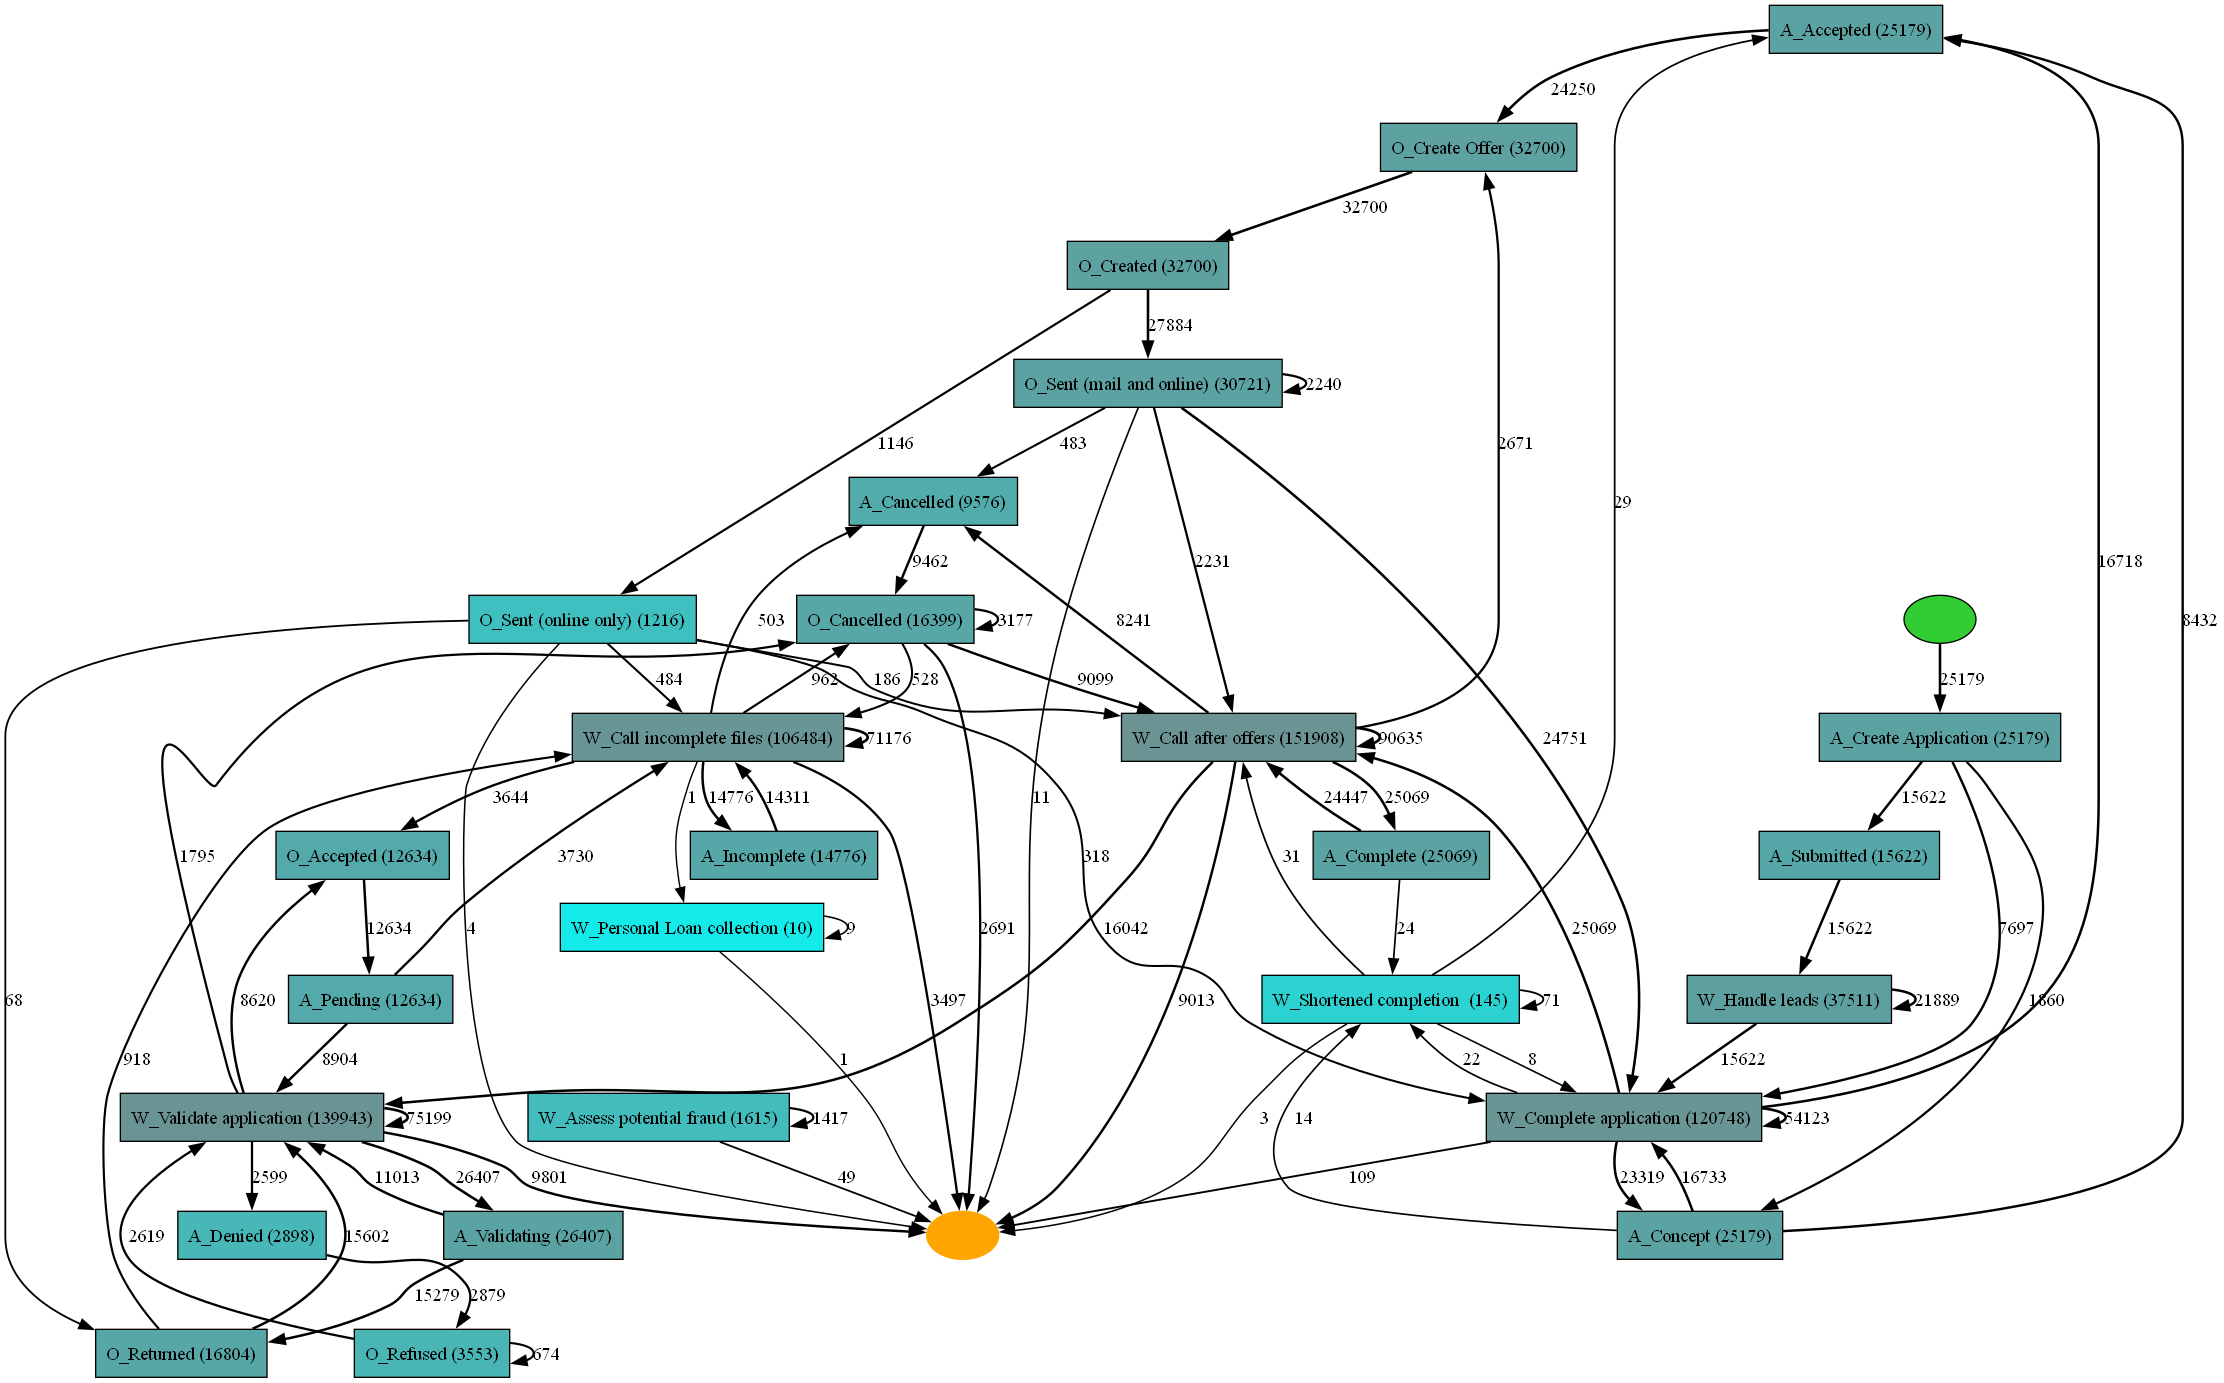

In [149]:
net = pm4py.discover_heuristics_net(variants_simplified)
pm4py.view_heuristics_net(net)

In [3]:
# 80% of the variances
log_80 = pm4py.algo.filtering.log.variants.variants_filter.filter_log_variants_percentage(log.copy(), 0.80)


In [54]:
log_70 = pm4py.algo.filtering.log.variants.variants_filter.filter_log_variants_percentage(log, 0.70)

In [4]:
# Splitting log for Process discovery 80% training data and 20% test data
train_log, test_log = pm4py.split_train_test(log_80, 0.80)

In [39]:

heuristics_net80 = pm4py.discover_heuristics_net(train_log, dependency_threshold=0.9)
heuristics_petrinet, im, fm = pm4py.discover_petri_net_heuristics(train_log, dependency_threshold=0.9)

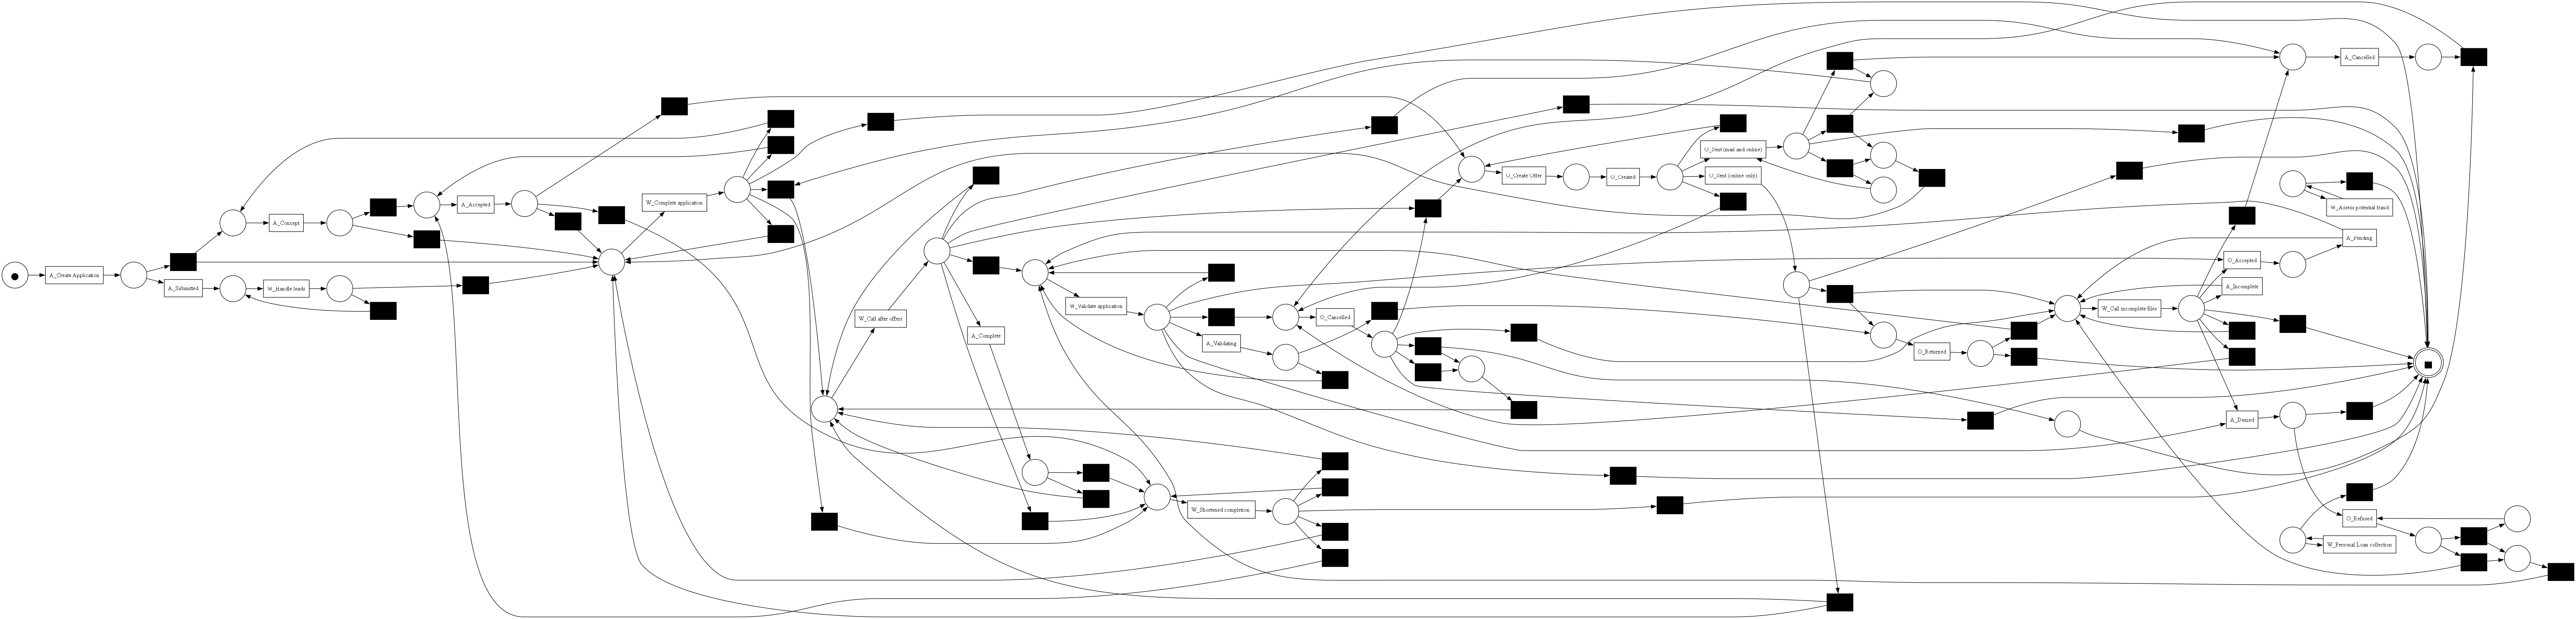

In [40]:
pm4py.view_petri_net(heuristics_petrinet, im, fm)

In [15]:
#convert it to bpmn
heuristics_bpmn = pm4py.convert_to_bpmn(heuristics_petrinet, im, fm)

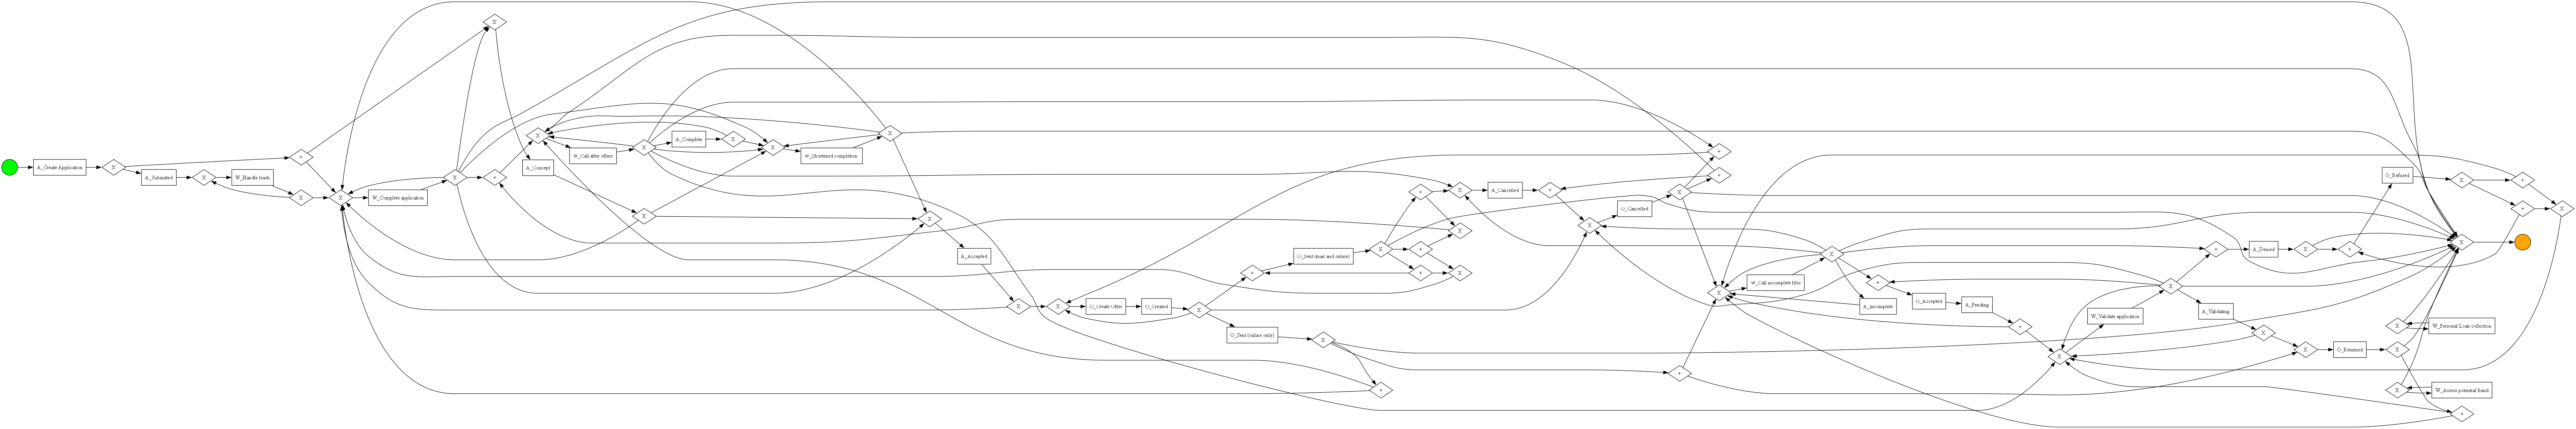

In [18]:
pm4py.view_bpmn(heuristics_bpmn)
## from the simplicity perspective the model looks really chaotic

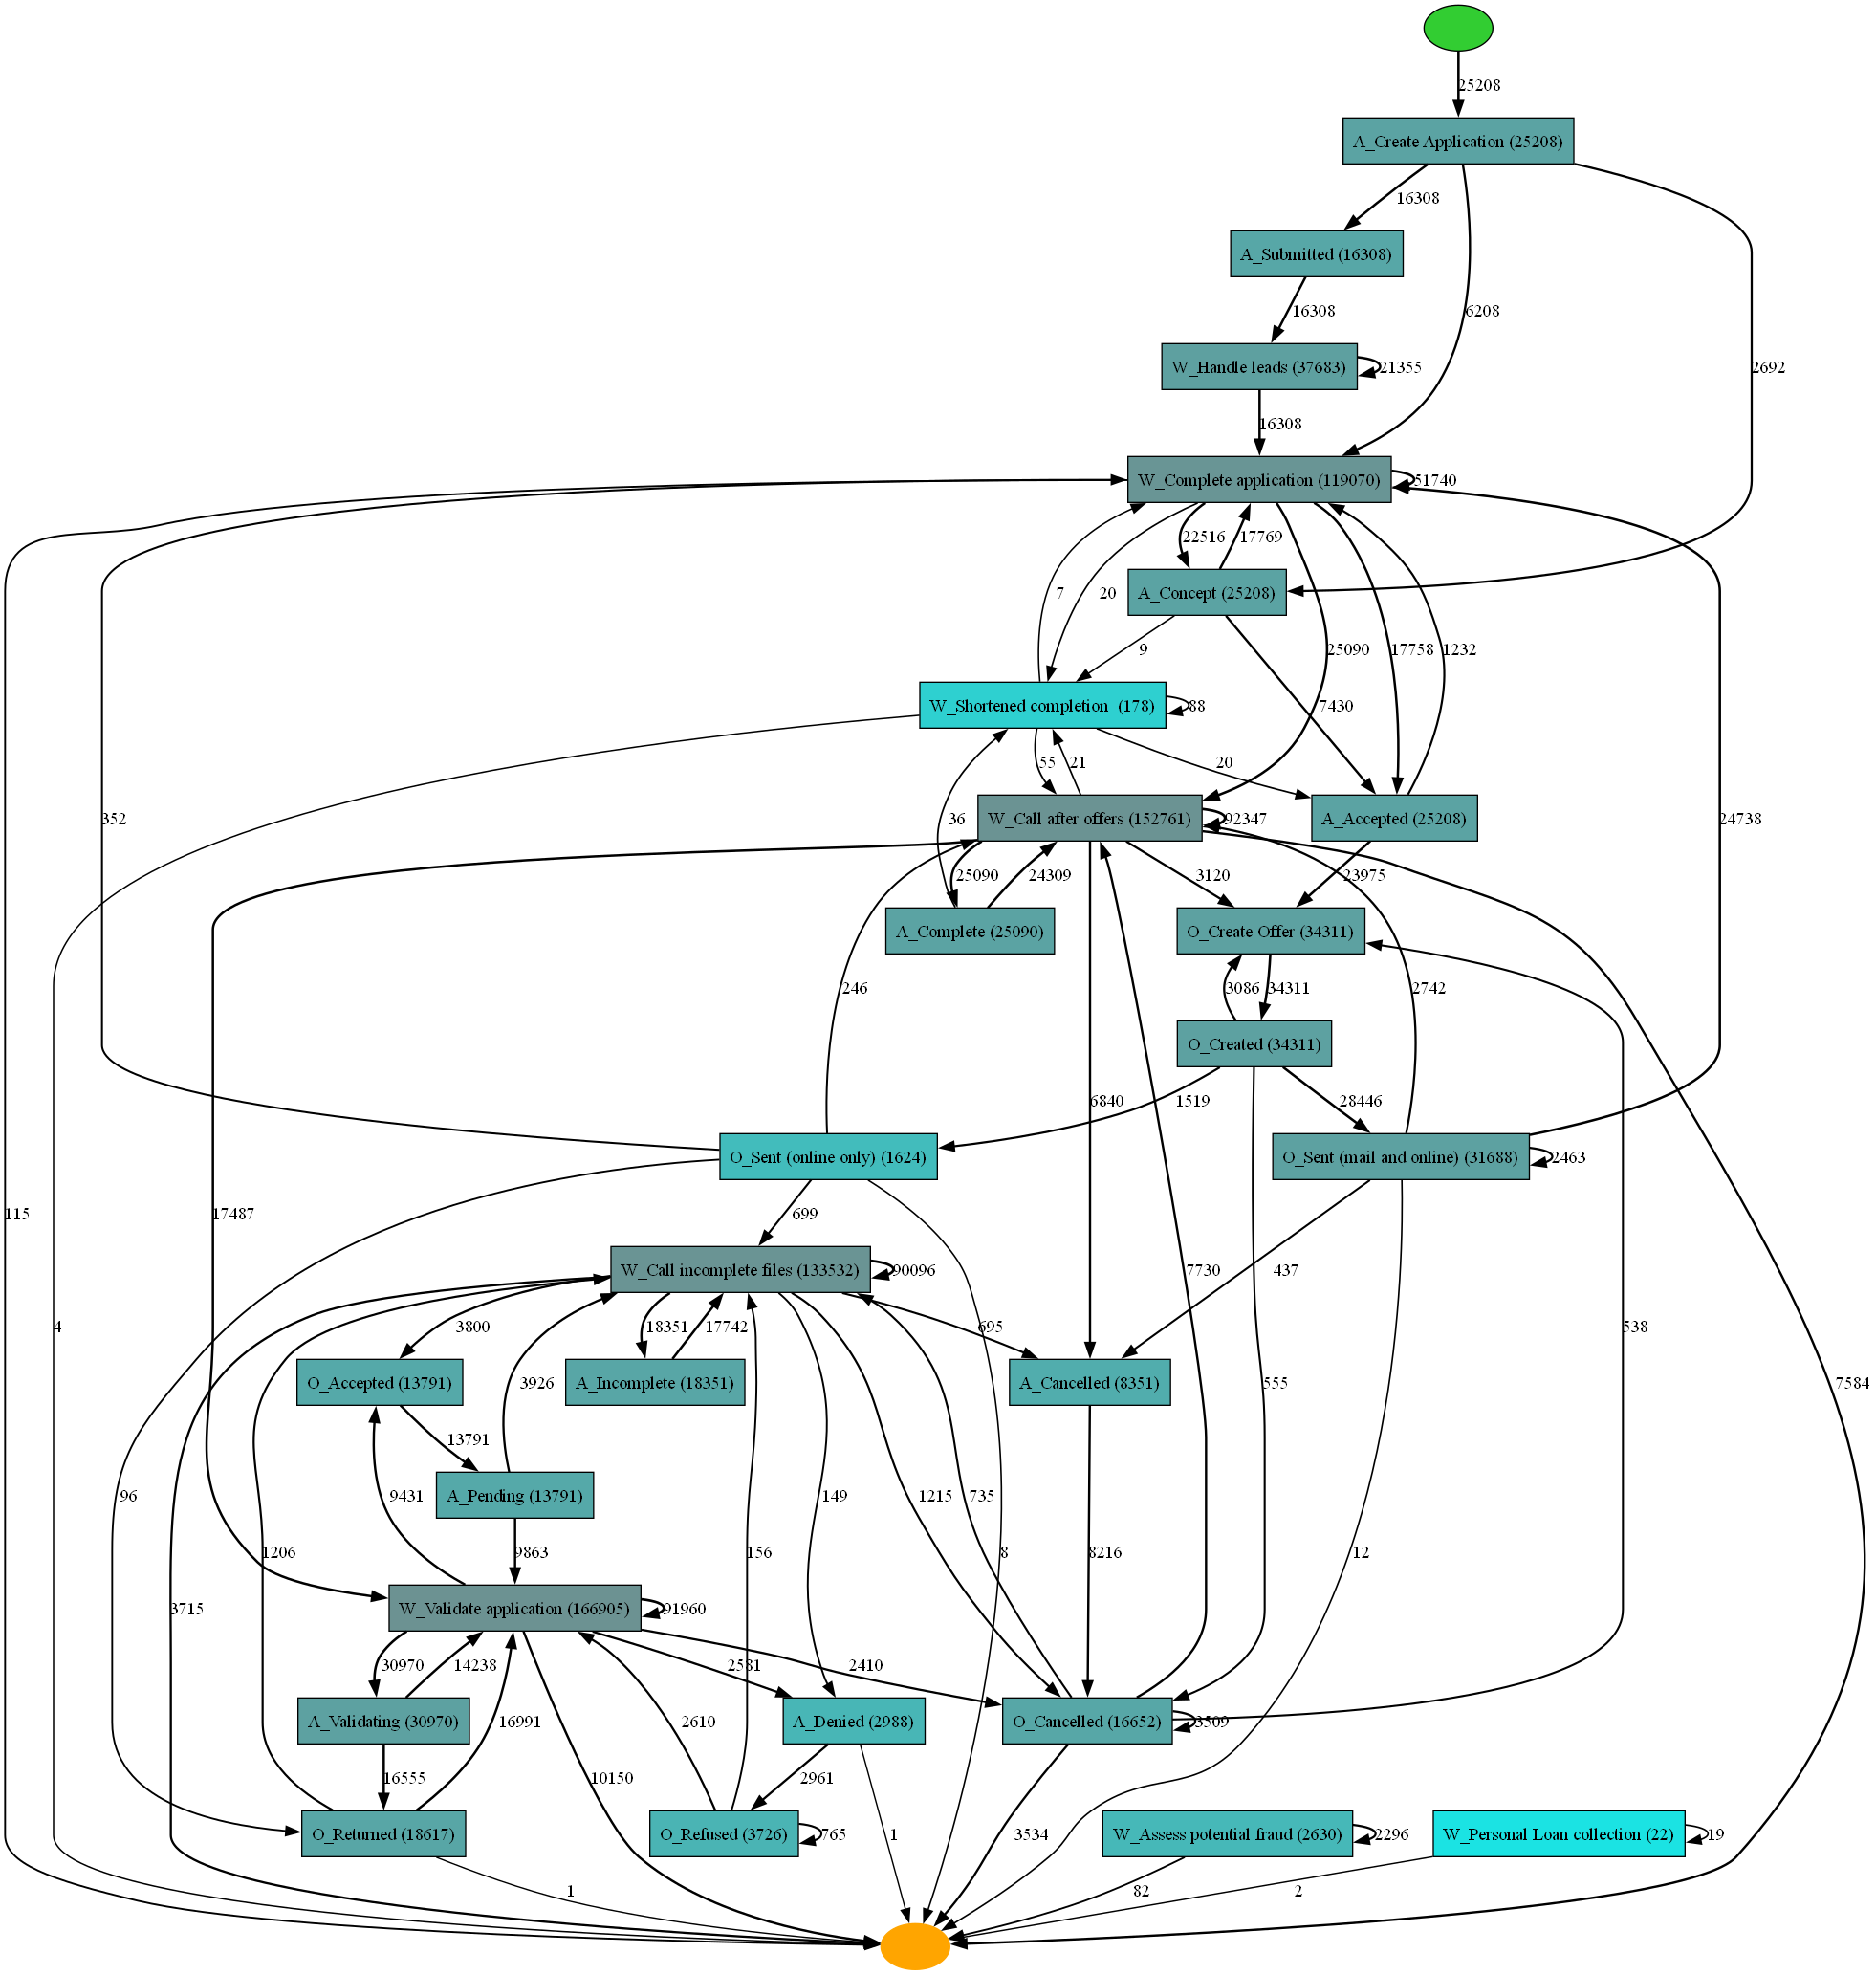

In [29]:
pm4py.view_heuristics_net(heuristics_net80)

In [33]:
#Token Based
# Precision
precision = pm4py.precision_token_based_replay(test_log, heuristics_petrinet, im, fm)


replaying log with TBR, completed traces :: 100%|██████████| 70753/70753 [01:56<00:00, 607.95it/s]


In [34]:
# Generalization
generalization_tbr = pm4py.generalization_tbr(log_80, heuristics_petrinet, im, fm)


replaying log with TBR, completed traces :: 100%|██████████| 15930/15930 [01:20<00:00, 198.07it/s]


In [39]:
# Fitness
fitness_tbr = pm4py.fitness_token_based_replay(test_log, heuristics_petrinet, im, fm)

replaying log with TBR, completed traces :: 100%|██████████| 3952/3952 [00:18<00:00, 212.21it/s]


In [98]:
# Simplicity
simplicity_tbr = pm4py.simplicity_petri_net(heuristics_petrinet, im, fm, variant='extended_cardoso')

In [40]:
print("The precision value of the token-based method is: ", precision)
print("The fitness value of the token-based method is: ", fitness_tbr)
print("The simplicity values of the token-based method is: ", simplicity_tbr)
print("The generalization value of the token-based method is: ", generalization_tbr)

The precision value of the token-based method is:  0.6054961623392432
The fitness value of the token-based method is:  {'perc_fit_traces': 0.0, 'average_trace_fitness': 0.9467640364922468, 'log_fitness': 0.9535774420946306, 'percentage_of_fitting_traces': 0.0}
The simplicity values of the token-based method is:  0.5183673469387755
The generalization value of the token-based method is:  0.9341441010142444


In [14]:
# Alignments
# Precision
precision_alignments = pm4py.precision_alignments(test_log, heuristics_petrinet, im, fm)


aligning log, completed variants ::   6%|▌         | 241/3872 [46:38<11:42:36, 11.61s/it]
computing precision with alignments, completed variants :: 100%|██████████| 68111/68111 [10:44<00:00, 105.70it/s] 


In [15]:
precision_alignments

0.5924580636639809

In [13]:
# TODO
diagnostics_alignments = pm4py.conformance_diagnostics_alignments(test_log, heuristics_petrinet, im, fm)

NameError: name 'precision_alignments' is not defined

In [12]:
# Fitness
fitness_alignments = pm4py.fitness_alignments(test_log, heuristics_petrinet, im, fm, multi_processing=False)

C:\Users\kickb\OneDrive\Escritorio\Praktikum BPM and Process Simulation\Project_Loan_Applications_Analysis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
aligning log, completed variants ::   6%|▌         | 241/3872 [30:59<51:35:57, 51.16s/it]  

KeyboardInterrupt: 

In [ ]:
# Generalization
generalization_alignments_heuristics = fitness_alignments['log_fitness']

In [2]:
print("The precision value of the alignment method is: ", precision_alignments)
print("The fitness value of the alignment method is: ", fitness_alignments)
print("The generalization value of the alignment method is: ", generalization_alignments_heuristics)

NameError: name 'precision_alignments' is not defined

In [317]:
# Other simplicity measures (self-implementation)
#hk_simplicity_heuristics = calculate_henry_kafura_complexity(heuristics_petrinet)
ccf_simplicity_heuristics = calculate_control_flow_complexity(heuristics_petrinet)

In [318]:
#print("Simplicity value (AAD): ", hk_simplicity_heuristics)
print("Simplicity value (CCF): ", ccf_simplicity_heuristics)

Simplicity value (CCF):  81


### Process variances for different LoanGoal values (heuristics miner)

In [4]:
df1 = pm4py.convert_to_dataframe(log)
df1

Action org:resource            concept:name  EventOrigin  \
0            Created       User_1    A_Create Application  Application   
1        statechange       User_1             A_Submitted  Application   
2            Created       User_1          W_Handle leads     Workflow   
3            Deleted       User_1          W_Handle leads     Workflow   
4            Created       User_1  W_Complete application     Workflow   
...              ...          ...                     ...          ...   
1202262      Deleted       User_1     W_Call after offers     Workflow   
1202263      Created       User_1     W_Call after offers     Workflow   
1202264  statechange      User_28             A_Cancelled  Application   
1202265  statechange      User_28             O_Cancelled        Offer   
1202266      Deleted      User_28     W_Call after offers     Workflow   

                       EventID lifecycle:transition  \
0        Application_652823628             complete   
1         ApplState_1582051990             complete   
2          Workitem_1298499574             schedule   
3          Workitem_1673366067             withdraw   
4          Workitem_1493664571             schedule   
...                        ...                  ...   
1202262    Workitem_1817549786            ate_abort   
1202263     Workitem_363876066             schedule   
1202264   ApplState_1869071797             complete   
1202265   OfferState_420066181             complete   
1202266    Workitem_1934044935             withdraw   

                          time:timestamp           case:LoanGoal  \
0       2016-01-01 09:51:15.304000+00:00  Existing loan takeover   
1       2016-01-01 09:51:15.352000+00:00  Existing loan takeover   
2       2016-01-01 09:51:15.774000+00:00  Existing loan takeover   
3       2016-01-01 09:52:36.392000+00:00  Existing loan takeover   
4       2016-01-01 09:52:36.403000+00:00  Existing loan takeover   
...                                  ...                     ...   
1202262 2017-01-06 06:33:02.212000+00:00        Home improvement   
1202263 2017-01-06 06:33:02.221000+00:00        Home improvement   
1202264 2017-01-16 09:51:21.114000+00:00        Home improvement   
1202265 2017-01-16 09:51:21.139000+00:00        Home improvement   
1202266 2017-01-16 09:51:21.146000+00:00        Home improvement   

        case:ApplicationType       case:concept:name  case:RequestedAmount  \
0                 New credit   Application_652823628               20000.0   
1                 New credit   Application_652823628               20000.0   
2                 New credit   Application_652823628               20000.0   
3                 New credit   Application_652823628               20000.0   
4                 New credit   Application_652823628               20000.0   
...                      ...                     ...                   ...   
1202262           New credit  Application_1350494635               20000.0   
1202263           New credit  Application_1350494635               20000.0   
1202264           New credit  Application_1350494635               20000.0   
1202265           New credit  Application_1350494635               20000.0   
1202266           New credit  Application_1350494635               20000.0   

         FirstWithdrawalAmount  NumberOfTerms Accepted  MonthlyCost Selected  \
0                          NaN            NaN      NaN          NaN      NaN   
1                          NaN            NaN      NaN          NaN      NaN   
2                          NaN            NaN      NaN          NaN      NaN   
3                          NaN            NaN      NaN          NaN      NaN   
4                          NaN            NaN      NaN          NaN      NaN   
...                        ...            ...      ...          ...      ...   
1202262                    NaN            NaN      NaN          NaN      NaN   
1202263                    NaN            NaN      NaN          NaN   

In [5]:
# Car
car_df = df1[df1['case:LoanGoal'] == 'Car']
car_log = pm4py.convert_to_event_log(car_df)
variants_car = pm4py.get_variants(car_log)

car_net = pm4py.discover_heuristics_net(car_log)

print("The number of variances in car applications is: ", len(variants_car))



The number of variances in car applications is:  5069


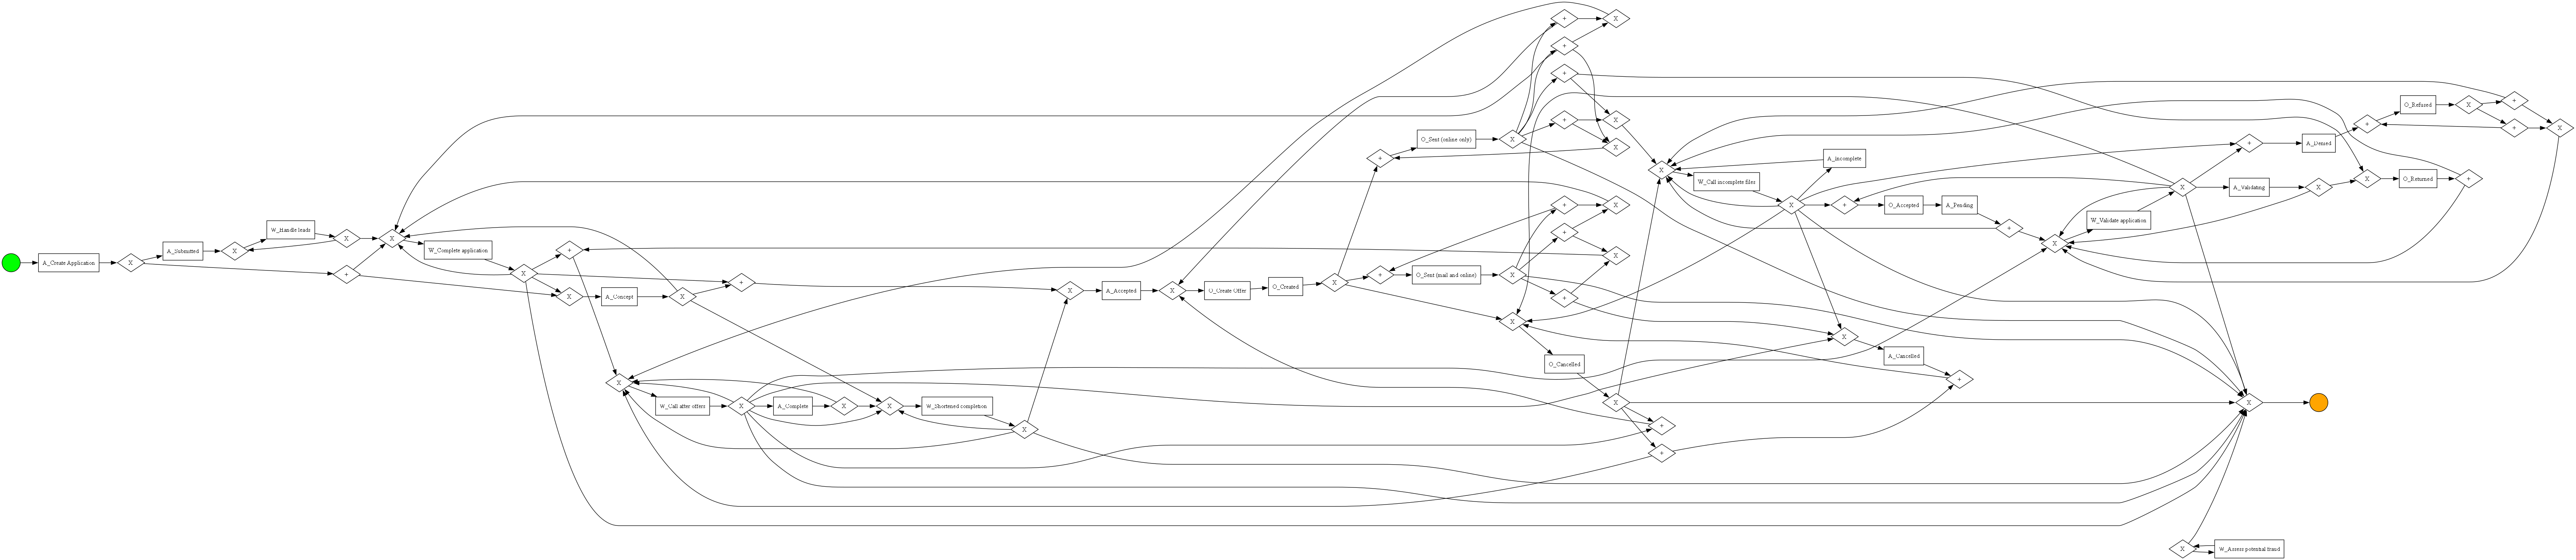

In [11]:
#pm4py.view_heuristics_net(car_net)
bmpn_car = pm4py.convert_to_bpmn(car_net)
pm4py.view_bpmn(bmpn_car)

In [214]:
# home improvement
hi_df = df1[df1['case:LoanGoal'] == 'Home improvement']
hi_log = pm4py.convert_to_event_log(hi_df)
variants_hi = pm4py.get_variants(hi_log)

hi_net = pm4py.discover_heuristics_net(hi_log)

print("The number of variances in Home improment is: ", len(variants_hi))


The number of variances in Home improment is:  4535


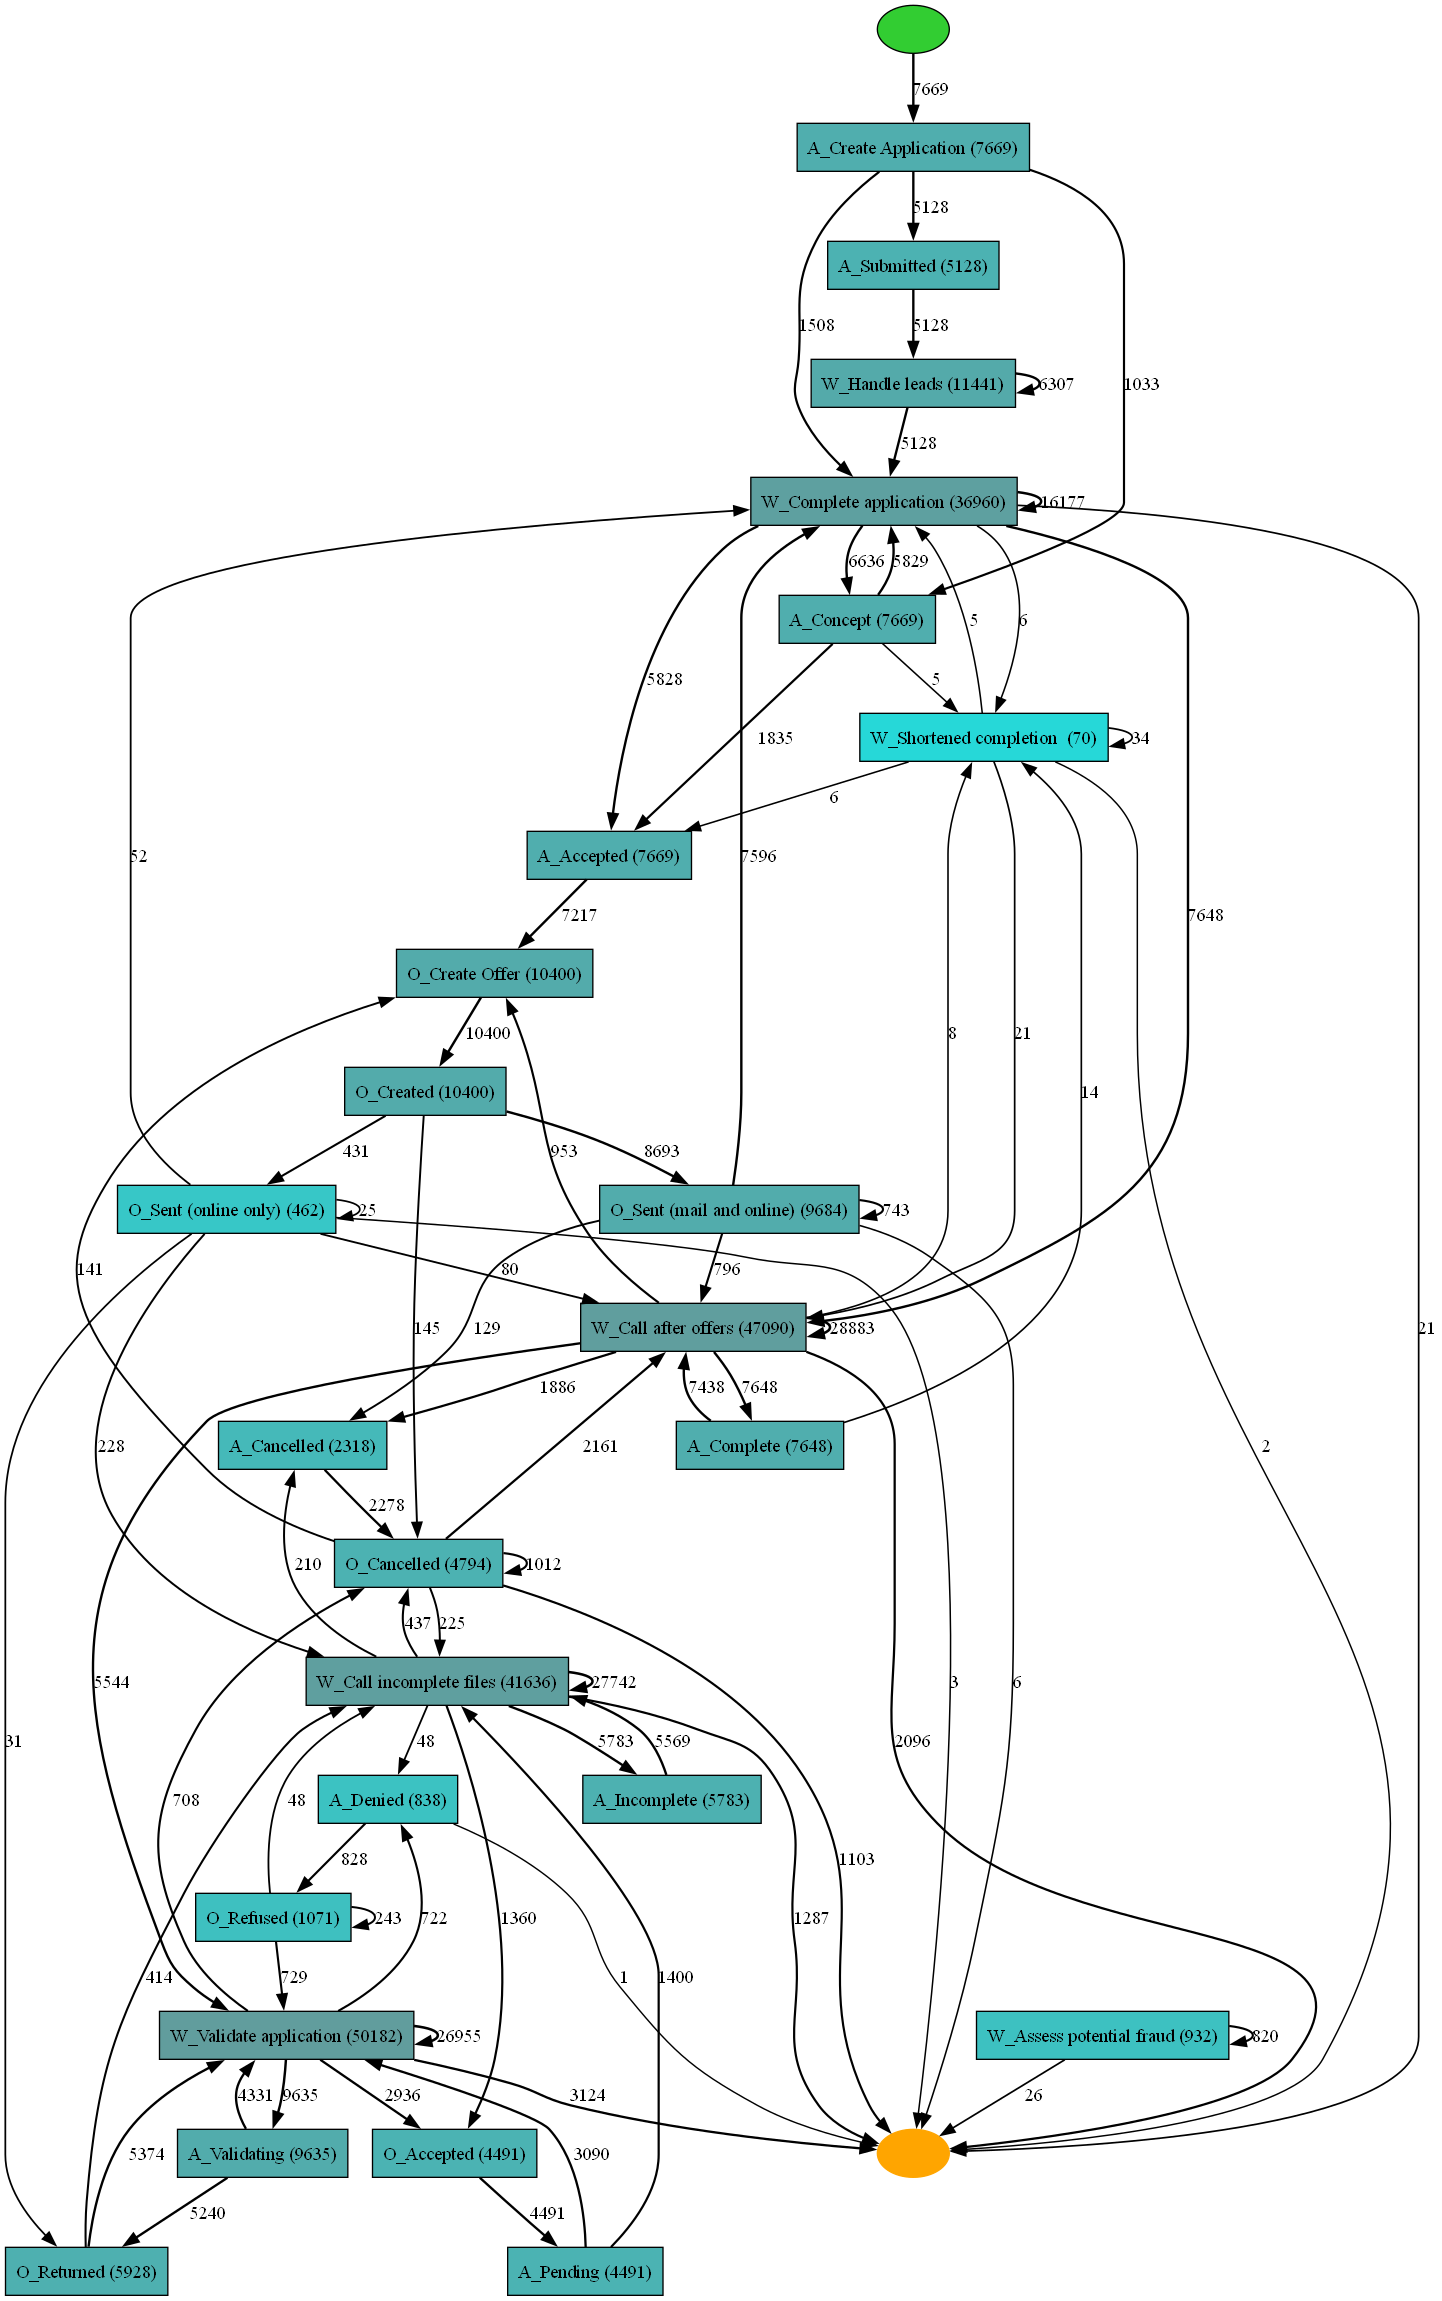

In [216]:
pm4py.view_heuristics_net(hi_net)

In [13]:
# net for motorcycle
motorcycle_df = df1[df1['case:LoanGoal'] == 'Motorcycle']
motorcycle_log = pm4py.convert_to_event_log(motorcycle_df)
variants_motorcycle = pm4py.get_variants(motorcycle_log)

motorcycle_net = pm4py.discover_heuristics_net(motorcycle_log)

print("The number of variances in Motorcycle is: ", len(variants_motorcycle))

The number of variances in Motorcycle is:  221


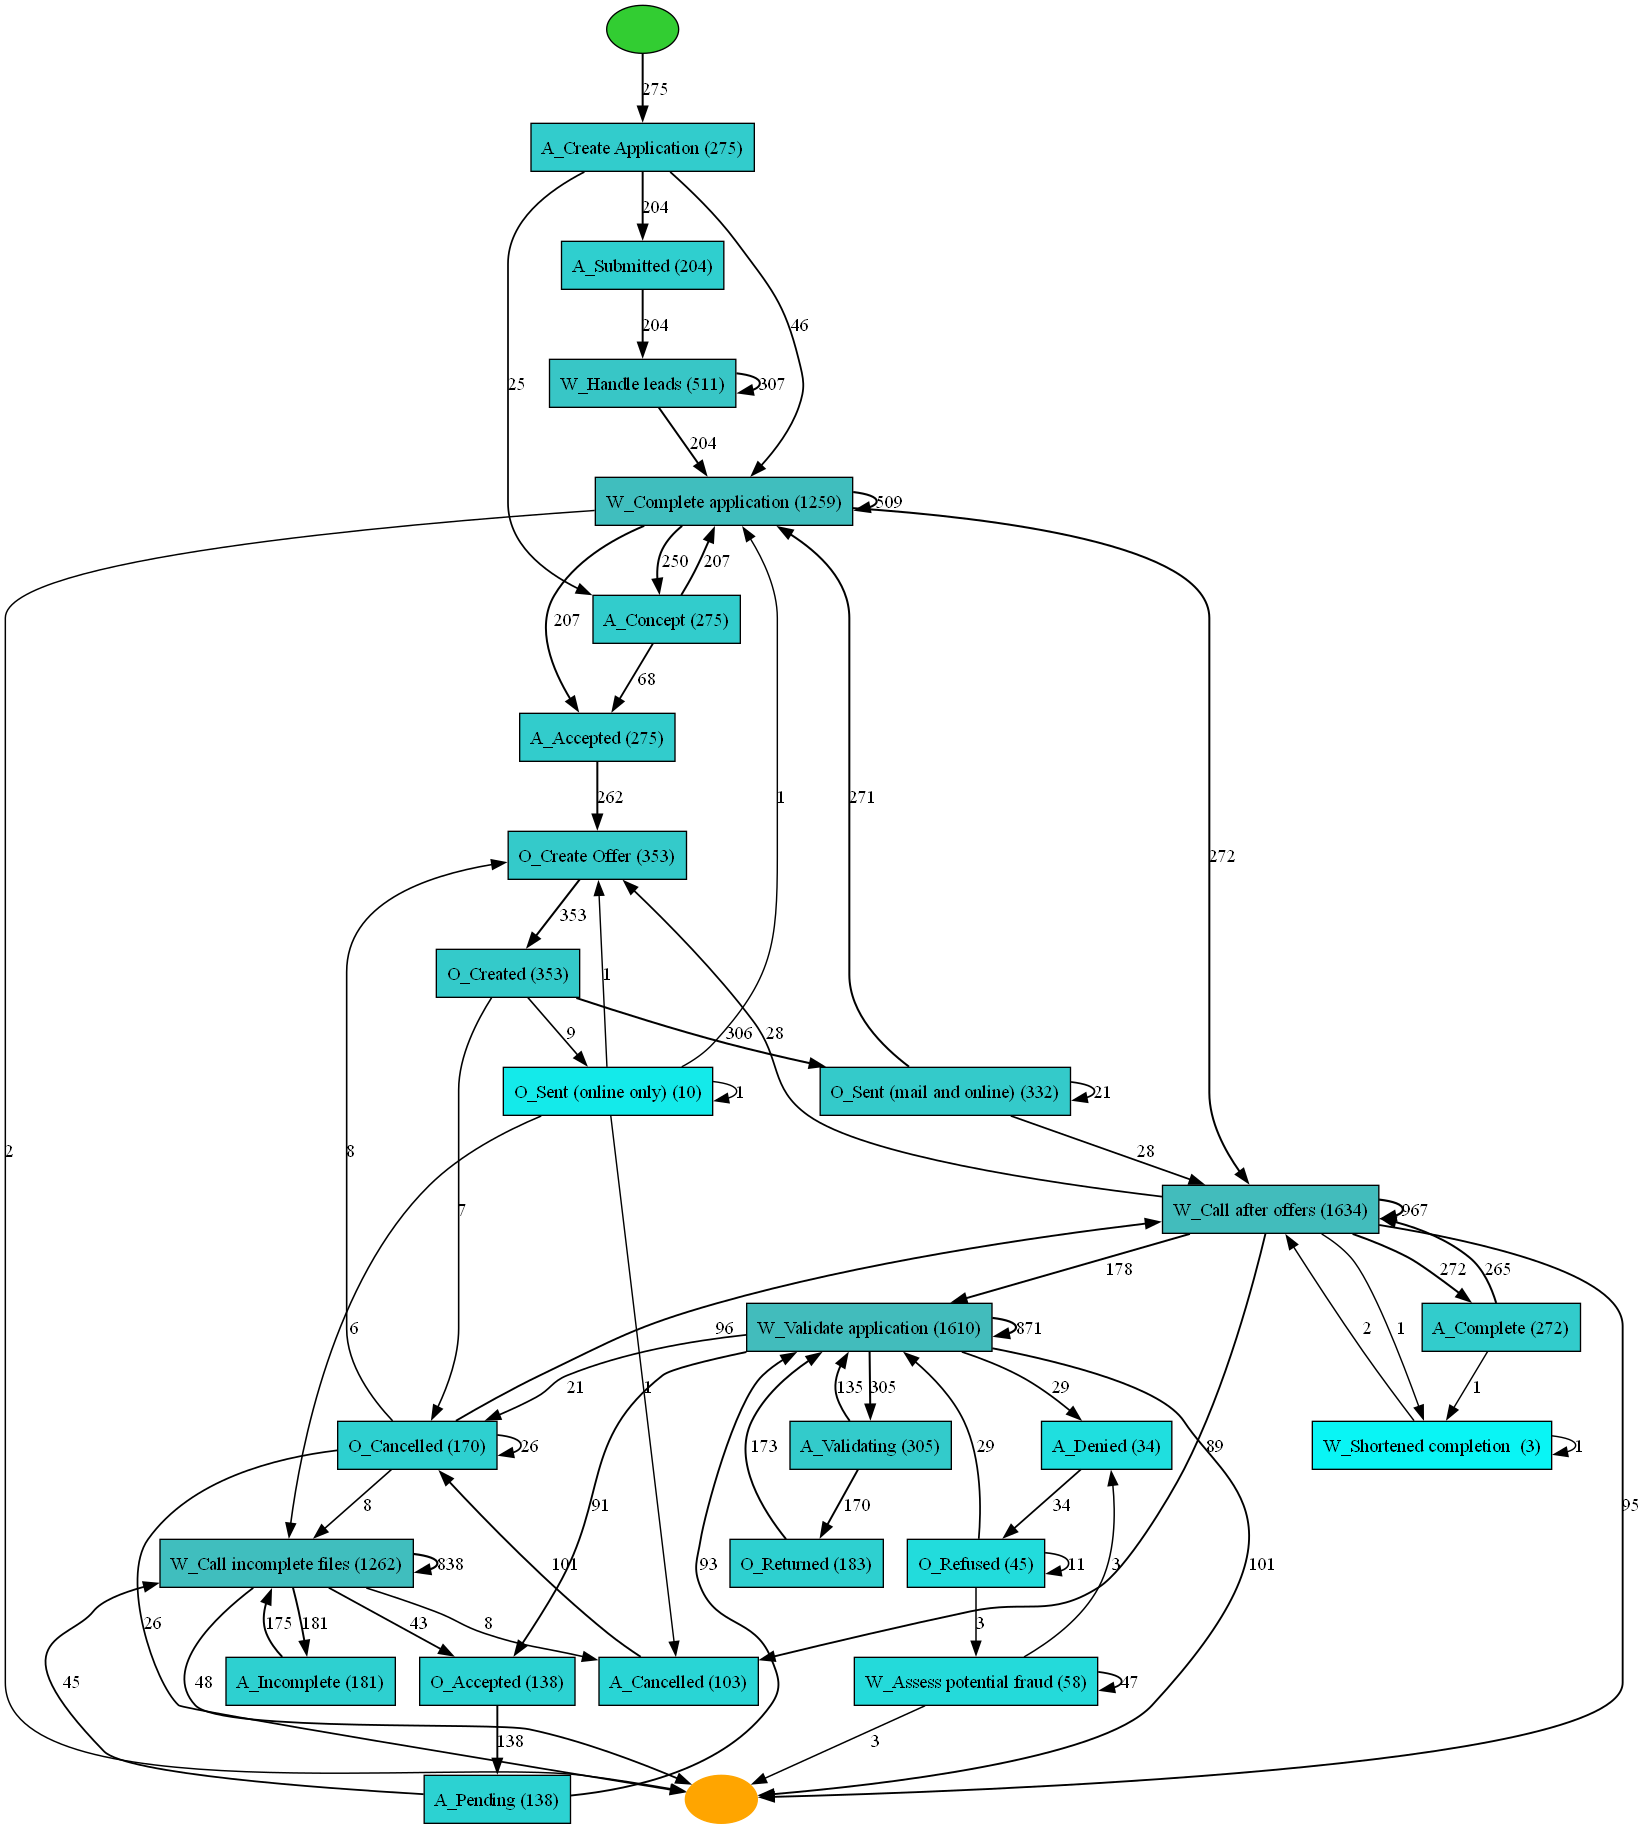

In [14]:
pm4py.view_heuristics_net(motorcycle_net)

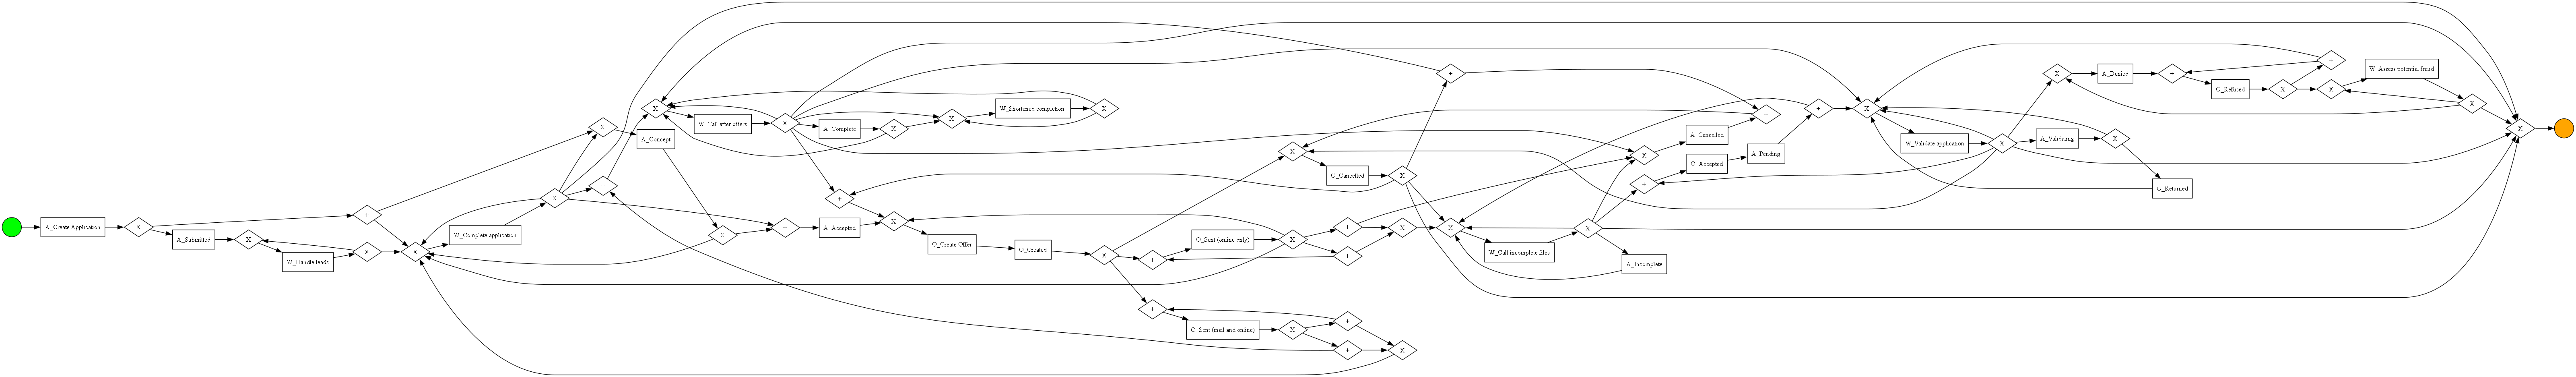

In [15]:
bmpn_motorcycle = pm4py.convert_to_bpmn(motorcycle_net)
pm4py.view_bpmn(bmpn_motorcycle)

### Alpha miner

In [17]:
alpha_net80, im1, fm1= pm4py.discover_petri_net_alpha(train_log)

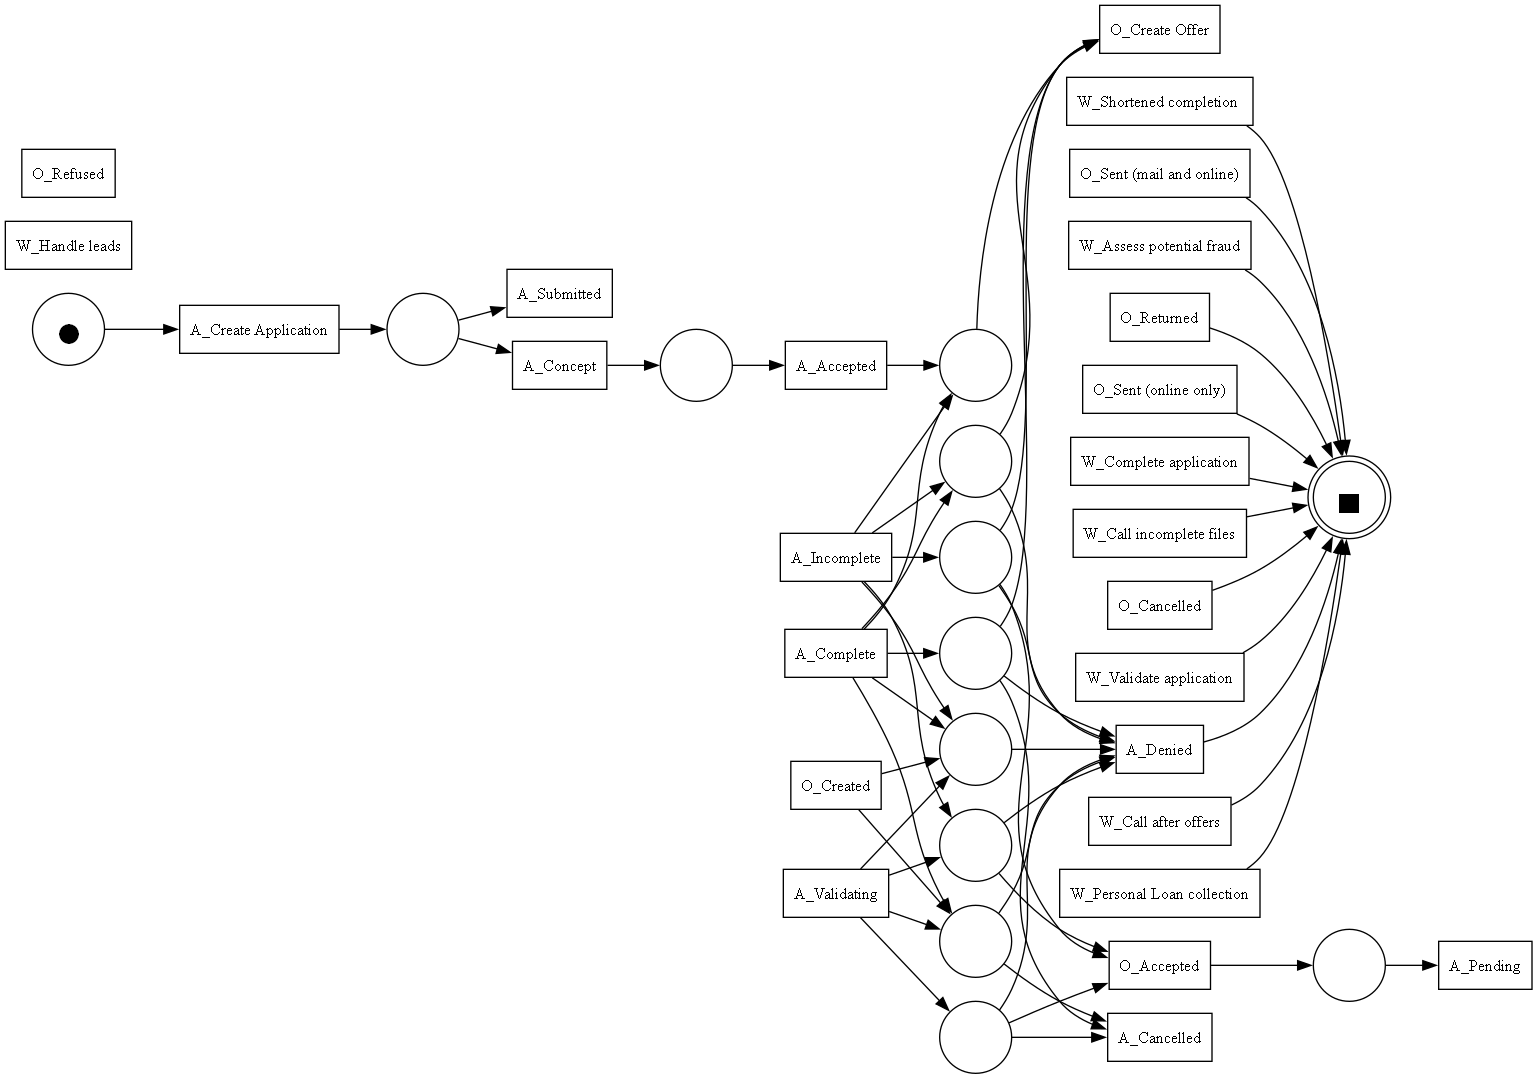

In [18]:
pm4py.view_petri_net(alpha_net80, im1, fm1)

In [62]:
# Conformance checking Token-based
# Precision
precision_tbr_alpha80 = pm4py.precision_token_based_replay(log_80, alpha_net80, im1, fm1)


replaying log with TBR, completed traces :: 100%|██████████| 263907/263907 [05:58<00:00, 735.36it/s] 


In [65]:
# Fitness
fitness_tbr_alpha80 = pm4py.fitness_token_based_replay(log_80, alpha_net80, im1, fm1)


replaying log with TBR, completed traces :: 100%|██████████| 15930/15930 [00:29<00:00, 540.89it/s]


In [25]:
# Generalization
generalization_tbr_alpha80 = pm4py.generalization_tbr(log_80, alpha_net80, im1, fm1)

replaying log with TBR, completed traces :: 100%|██████████| 15930/15930 [00:30<00:00, 519.73it/s]


In [96]:
# Simplicity
simplicity_tbr_alpha80 = pm4py.simplicity_petri_net(alpha_net80, im1, fm1, variant='extended_cardoso')

In [93]:
print("Precision value (TBR): ", precision_tbr_alpha80)
print("Fitness values (TBR): ", fitness_tbr_alpha80)
print("Generalization value (TBR): ", generalization_tbr_alpha80)
print("Simplicity value (TBR): ", simplicity_tbr_alpha80)


NameError: name 'precision_tbr_alpha80' is not defined

In [19]:
# Alignment
# Precision
precision_alignments_alpha80 = pm4py.precision_alignments(log_80,alpha_net80, im1, fm1)

computing precision with alignments, completed variants :: 100%|██████████| 263907/263907 [12:16<00:00, 358.38it/s] 


In [21]:
# Fitness
fitness_alignments_alpha80 = pm4py.fitness_alignments(log_80,alpha_net80, im1, fm1)

aligning log, completed variants :: 100%|██████████| 15930/15930 [22:52<00:00, 11.61it/s] 


In [94]:
print("Precision value (Alignments): ", precision_alignments_alpha80)
print("Fitness values (Alignments): ", fitness_alignments_alpha80)
print("Generalization value (Alignments): ", fitness_alignments_alpha80['log_fitness'])
print("Simplicity value (Alignments): ", simplicity_tbr_alpha80)

Precision value (Alignments):  0.09036668421905925
Fitness values (Alignments):  {'percFitTraces': 0.0, 'averageFitness': 0.19043267096909805, 'percentage_of_fitting_traces': 0.0, 'average_trace_fitness': 0.19043267096909805, 'log_fitness': 0.16875540756666052}
Generalization value (Alignments):  0.16875540756666052
Simplicity value (Alignments):  13


In [126]:
# Other simplicity measures (self-implementation)
aad_simplicity_alpha = calculate_avg_arc_degree(alpha_net80)
ccf_simplicity_alpha = calculate_control_flow_complexity(alpha_net80)

In [127]:
print("Simplicity value (AAD): ", aad_simplicity_alpha)
print("Simplicity value (CCF): ", ccf_simplicity_alpha)

Simplicity value (AAD):  0.5652173913043479
Simplicity value (CCF):  21


### Inductive Miner

In [21]:
inductive_net, im2, fm2 = pm4py.discover_petri_net_inductive(train_log, noise_threshold=0.9)

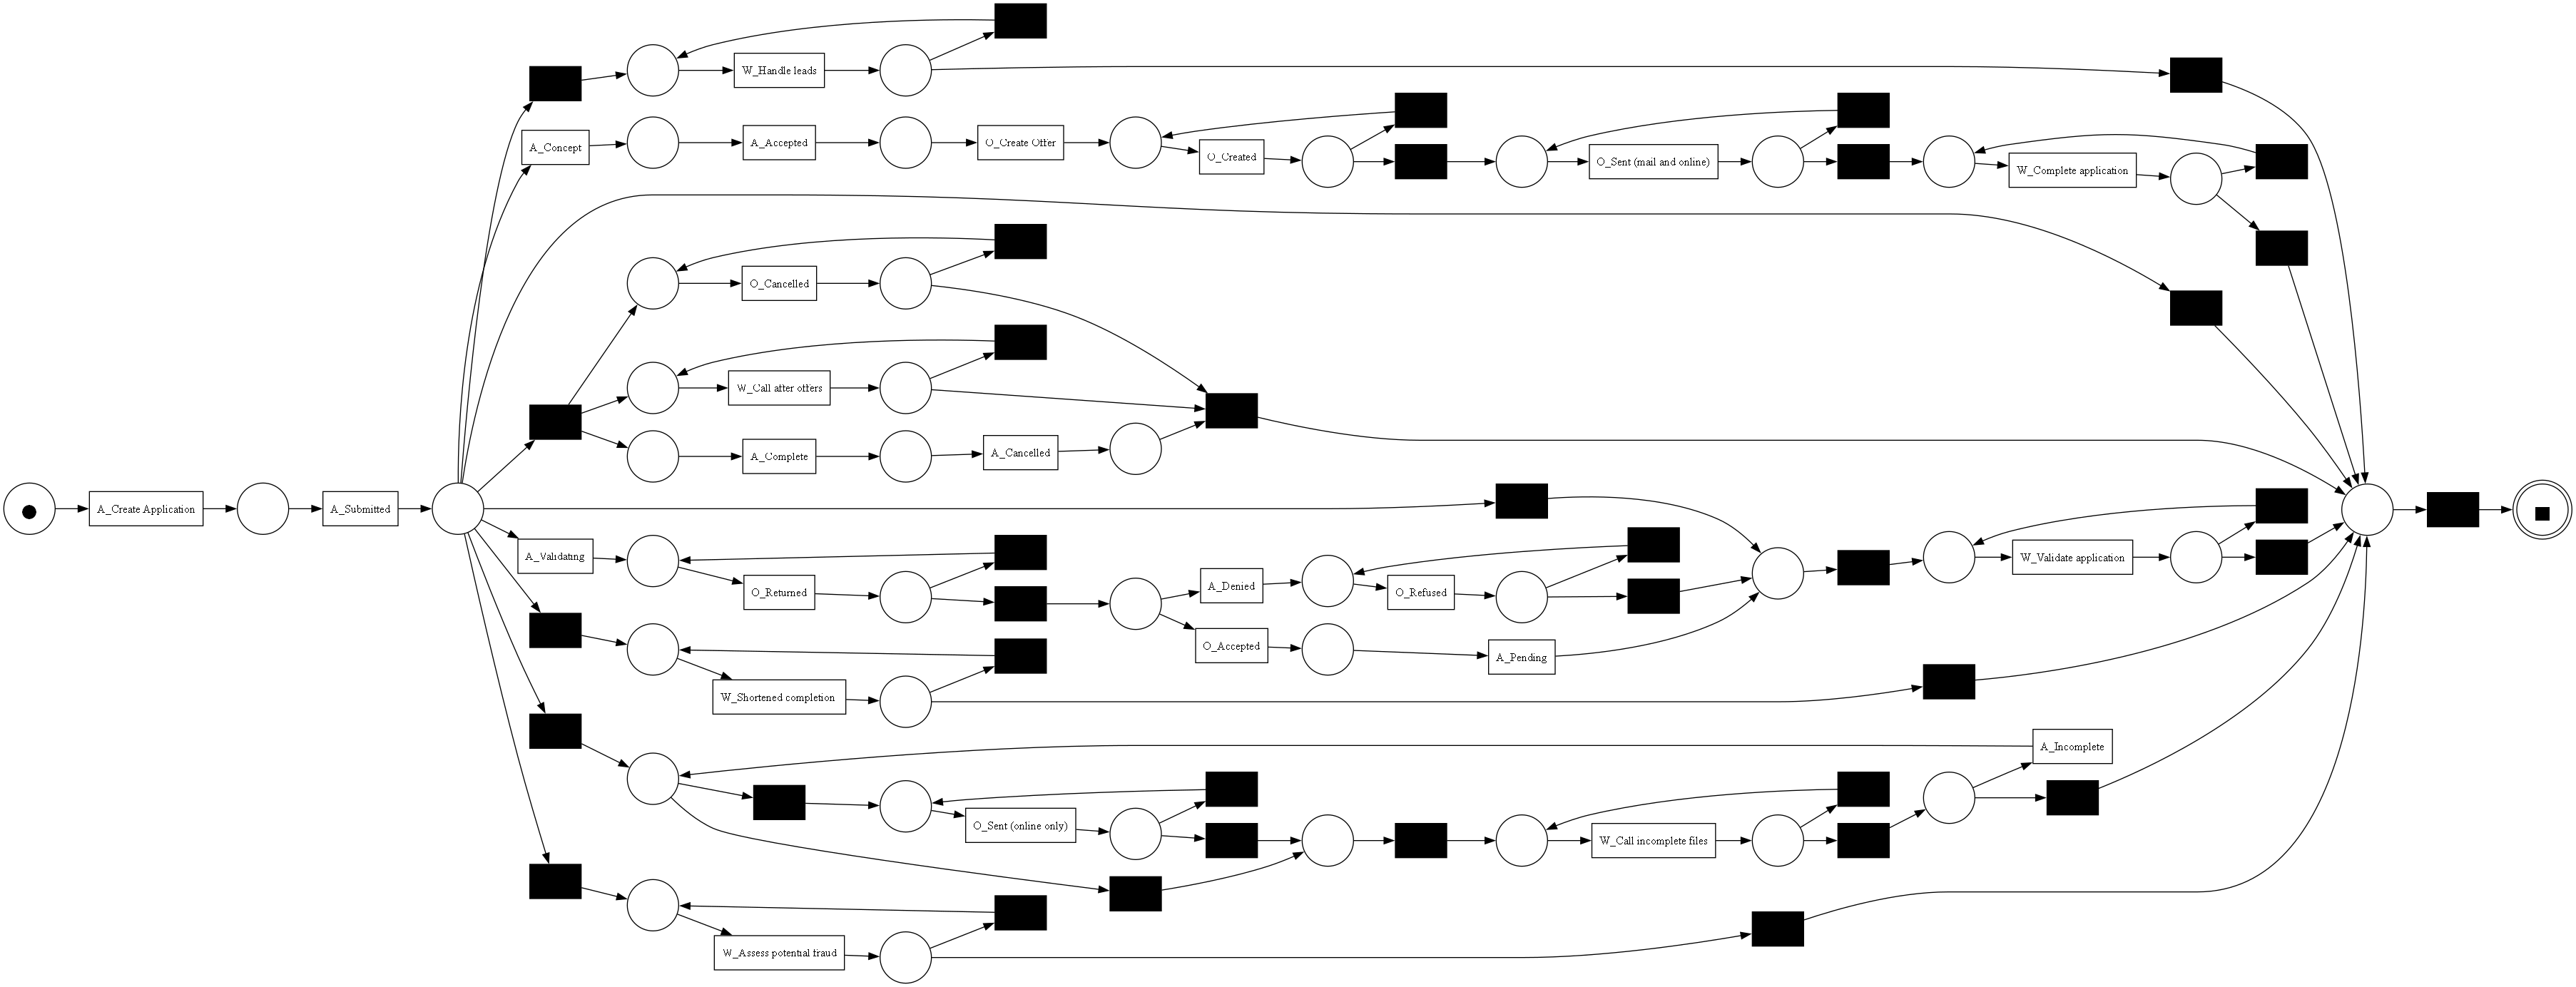

In [77]:
pm4py.view_petri_net(inductive_net, im2, fm2)

In [269]:
## Conformance checking Alignmnent
# Fitness
fitness_align_inductive = pm4py.fitness_alignments(test_log, inductive_net, im2, fm2)

aligning log, completed variants :: 100%|██████████| 3872/3872 [3:45:38<00:00,  3.50s/it]   


In [270]:
fitness_align_inductive

{'percFitTraces': 0.0,
 'averageFitness': 0.9358869222918476,
 'percentage_of_fitting_traces': 0.0,
 'average_trace_fitness': 0.9358869222918476,
 'log_fitness': 0.932104784564455}

In [ ]:
# Generalization
generalization_align_inductive1 = fitness_align_inductive['log_fitness']

In [267]:
# Precision
precision_align_inductive = pm4py.precision_alignments(test_log, inductive_net, im2, fm2)

computing precision with alignments, completed variants :: 100%|██████████| 68111/68111 [09:46<00:00, 116.13it/s] 


In [268]:
precision_align_inductive

0.24151150963660895

In [129]:
# Simplicity
simplicity_align_inductive = pm4py.simplicity_petri_net(inductive_net, im2, fm2, variant='extended_cardoso')

In [ ]:
print("Fitness values (Align): ", fitness_align_inductive)
print("Precision value (Align): ", precision_align_inductive)
print("Generalization value (Align):", generalization_align_inductive1)
print("Simplicity value (Align): ", simplicity_align_inductive)

In [85]:
# Conformance Checking Token-based
# Fitness
fitness_tbr_inductive = pm4py.fitness_token_based_replay(test_log, inductive_net, im2, fm2)


replaying log with TBR, completed traces :: 100%|██████████| 3872/3872 [00:26<00:00, 148.52it/s]


In [84]:
# Generalization
generalization_tbr_inductive1 = fitness_tbr_inductive['log_fitness']
generalization_tbr_inductive2 = pm4py.generalization_tbr(test_log,inductive_net, im2, fm2)


replaying log with TBR, completed traces :: 100%|██████████| 3872/3872 [00:26<00:00, 146.02it/s]


In [83]:
# Precision
precision_tbr_inductive = pm4py.precision_token_based_replay(test_log, inductive_net, im2, fm2)


replaying log with TBR, completed traces :: 100%|██████████| 68111/68111 [00:35<00:00, 1931.99it/s]


In [130]:
print("Fitness values (TBR): ", fitness_tbr_inductive)
print("Precision value (TBR): ", precision_tbr_inductive)
print("Generalization value (TBR):", generalization_tbr_inductive1, " or ", generalization_tbr_inductive2)
print("Simplicity value (TBR): ", simplicity_align_inductive)

Fitness values (TBR):  {'perc_fit_traces': 0.0, 'average_trace_fitness': 0.888382370675584, 'log_fitness': 0.8951775534493971, 'percentage_of_fitting_traces': 0.0}
Precision value (TBR):  0.3904146392429625
Generalization value (TBR): 0.8951775534493971  or  0.7629779115266846
Simplicity value (TBR):  73


In [14]:
print("Fitness values (TBR): ", fitness_tbr_inductive)
print("Precision value (TBR): ", precision_tbr_inductive)
print("Generalization value (TBR):", generalization_tbr_inductive1, " or ", generalization_tbr_inductive2)
print("Simplicity value (TBR): ", simplicity_align_inductive)

Fitness values (TBR):  {'perc_fit_traces': 39.23186795746707, 'average_trace_fitness': 0.9805738618157289, 'log_fitness': 0.9805980414943382, 'percentage_of_fitting_traces': 39.23186795746707}
Precision value (TBR):  0.19173931468893135
Generalization value (TBR): 0.9805980414943382  or  0.9064392909539217
Simplicity value (TBR):  0.642512077294686


In [24]:
# Other simplicity measures (self-implementation)
hk_simplicity_induct = calculate_henry_kafura_complexity(inductive_net)
ccf_simplicity_induct = calculate_control_flow_complexity(inductive_net)

In [25]:
print(hk_simplicity_induct)
print( ccf_simplicity_induct)


Henry Kafura Complexity: 368
Control Flow Complexity: 41


In [ ]:
result = pm4py.analysis.check_soundness()
result

## Inductive Miner for BPMN

In [28]:
# set parameter
k = 0.2 # Noise-Threshold

In [325]:
process_tree_bpmn = pm4py.discover_process_tree_inductive(log_80, noise_threshold=k)


C:\Users\kickb\AppData\Local\Temp\ipykernel_32168\3166482810.py:2: DeprecatedWarning: check_soundness is deprecated as of 2.3.0 and will be removed in 3.0.0. this method will be removed in a future release.
  result = pm4py.analysis.check_soundness(inductive_net, im2, fm2)
C:\Users\kickb\OneDrive\Escritorio\Praktikum BPM and Process Simulation\Project_Loan_Applications_Analysis\.venv\Lib\site-packages\pm4py\algo\analysis\woflan\place_invariants\utility.py:163: UserWarning: solution from scipy may be unstable. Please install PuLP (pip install pulp) for fully reliable results.
  warnings.warn(


(True,
 {'s_c_net': places: [ p_10, p_11, p_13, p_14, p_15, p_16, p_19, p_20, p_21, p_22, p_23, p_24, p_25, p_26, p_27, p_29, p_3, p_30, p_31, p_32, p_33, p_36, p_37, p_39, p_4, p_40, p_41, p_42, p_43, p_44, p_46, p_47, p_49, p_5, p_51, p_52, p_54, p_55, p_56, p_57, p_58, p_6, p_7, p_9, sink, source ]
  transitions: [ (0fab4555-a1b4-4aa7-942c-0d3d4cbc5a5a, 'W_Handle leads'), (10228fe7-4814-43ee-a36a-da6ce0afd503, 'A_Submitted'), (1527648b-95d1-47bd-a33f-99a037a71e97, 'O_Accepted'), (17ef6fd3-274c-40f6-9681-858fe06734b6, 'W_Call after offers'), (19b93556-dbd7-4441-94d2-b95065a5f187, 'A_Pending'), (2a945bb2-6d88-4c8c-9f4e-e6665a47d4e7, 'A_Concept'), (2d4b8b3b-35a0-4ef7-aa01-77094a1c4af5, 'W_Call incomplete files'), (337da804-a5fe-4e9d-be28-638539984475, 'W_Assess potential fraud'), (340cb6ac-e257-4a52-976e-acde9a4a0909, 'O_Sent (mail and online)'), (3adfab81-e2bc-4cca-ae65-f420ce4eff9e, 'O_Sent (online only)'), (4e8a63a3-5de5-46b4-925a-db2450156de6, 'W_Complete application'), (6e72b290-7

In [29]:
bpmn_inductive = pm4py.discover_bpmn_inductive(log_80, noise_threshold=k)

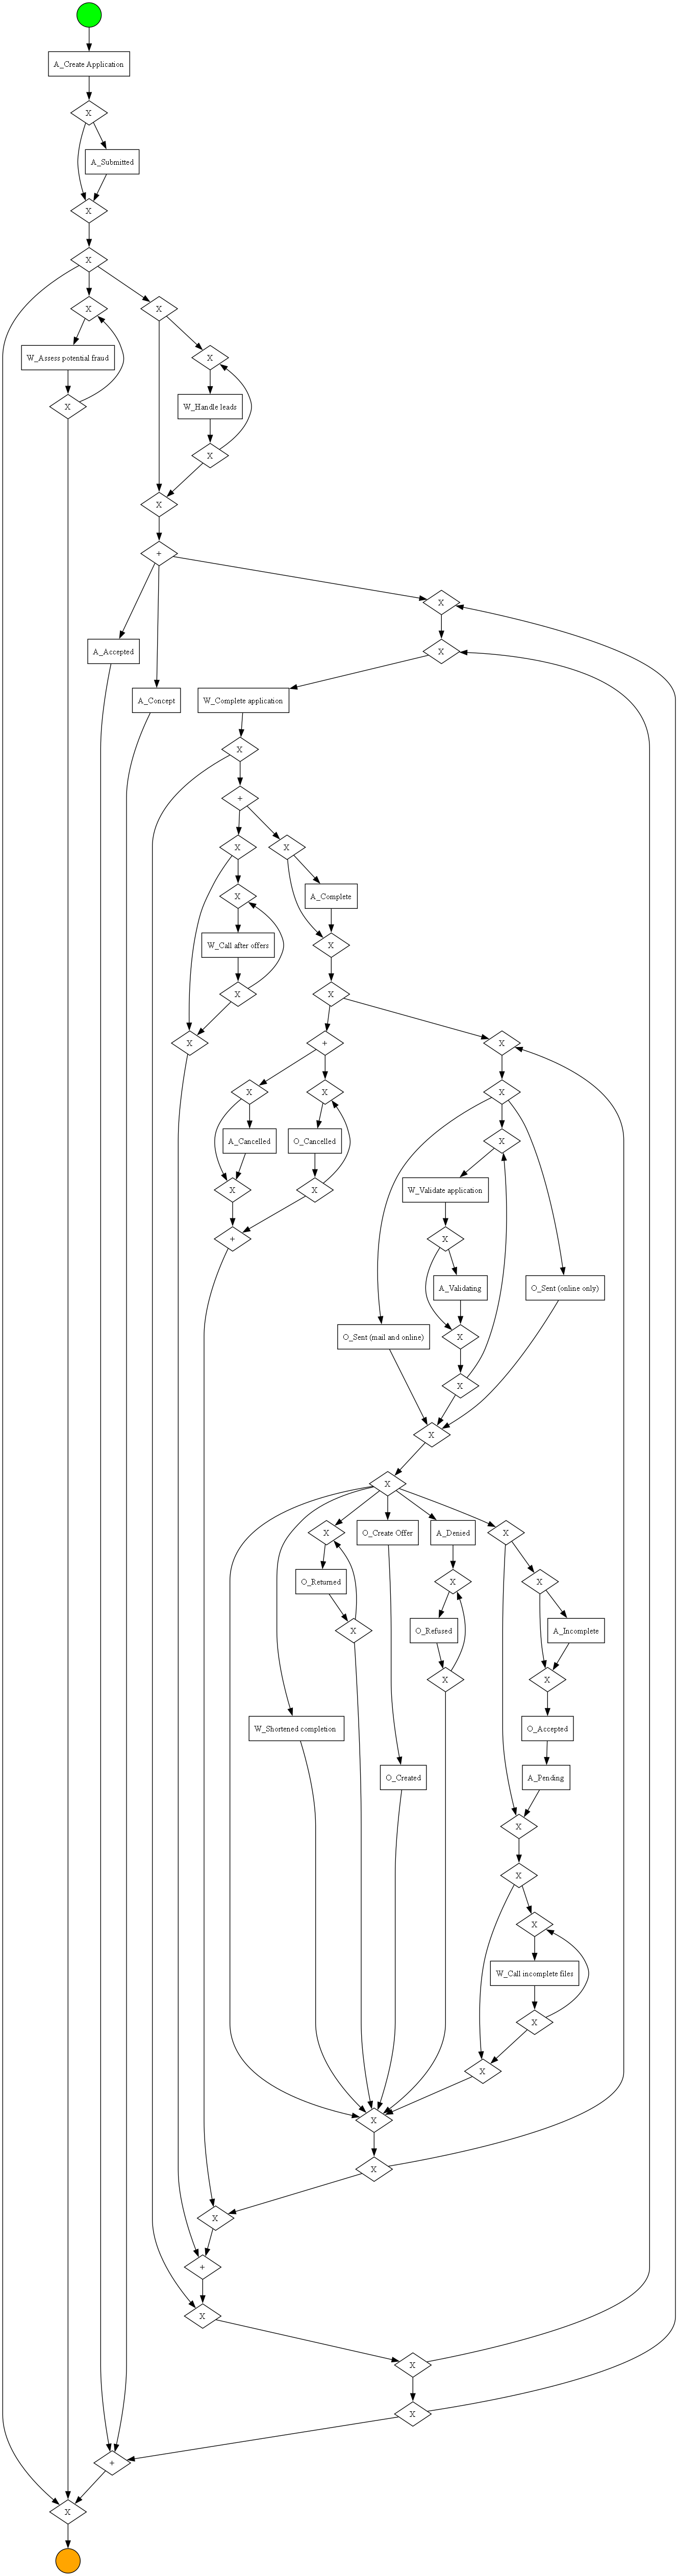

In [323]:
pm4py.view_bpmn(bpmn_inductive, rankdir='TB')

In [33]:
# save model in .bpmn file
pm4py.write_bpmn(bpmn_inductive, 'Final_Bpmn/Final_BPMN.bpmn')
